# **FED Textual Analysis Software (Beta version)**

We acknowledge the support of Elia Landini, Jessie Cameron & Lina Abril (Pantheon-Sorbonne University) in the development of this project.

**Edit Log: 30 May 2024, 5.15pm**

### **INTRODUCTION**

The project aims to conduct textual analysis of the Federal Reserve's (FED) Monetary Policy Reports through the deployment of Python-based software. This report is written semi-annually and provided to Congress containing discussions on the "conduct of monetary policy and economic developments and prospects for the future." 

First, we develop a web scraping script to extract textual data from the FED's website. Subsequently, we use the Natural Language Toolkit (NLTK) package to preprocess the text, including tokenization, stemming, and converting words to lowercase. Next, the Loughran McDonald Sentiment Dictionary is employed to transform the cleaned qualitative text data into a quantitative measure of the FED's communication tone. This communication measure is then be regressed against the output gap and inflation gap, obtained via API, to assess the sensitivity of the FED's communication to these macroeconomic variables. Throughout the project, we employ various visualisation and analysis packages to explore the data and conduct preliminary analysis. 

Finally, we plan to develop a user-friendly interface for easy access and interpretation of our findings. **IF WE GET TIME**

### **INSTALL PACKAGES**

In [1]:
!pip install pandas
!pip install matplotlib
!pip install requests-html
!pip install seaborn
!pip install numpy
!pip install schedule
!pip install statsmodels
!pip install reportlab
!pip install scipy
!pip install linearmodels
!pip install openai
!pip install fredapi
!pip install nltk
!pip install pysentiment2
!pip install scikit-learn
!pip install wordcloud

     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ---------------------------------------- 42.0/42.0 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.5 MB 245.8 kB/s eta 0:00:06
   - -------------------------------------- 0.0/1.5 MB 245.8 kB/s eta 0:00:06
   - -------------------------------------- 0.1/1.5 MB 252.2 kB/s eta 0:00:06
   - -------------------------------------- 0.1/1.5 MB 207.6 k

### **1. IMPORT TEXTUAL DATA: FED WEB SCRAPPING**

The following function retrives and filters text-based resources of the Fed's semi-annual Monetary Policy Report. The function is customized to scrape articles and filter text based on the topic and typology of the publication. 

Base URL-FED: https://www.federalreserve.gov/monetarypolicy/publications/mpr_default.htm

 #### 1.1 Fed Monetary Policy Report URL retrieval 

In [2]:
import requests
from bs4 import BeautifulSoup

In [3]:
# FED Scraping Function 

def fed_get_articles(topic, publication_type, sub_class):
    # Construct the base URL for fetching articles based on the topic, publication type, and subclass
    base_url = f"https://www.federalreserve.gov/{topic}/{publication_type}/mpr_default.htm"
    # Define the base domain for constructing full URLs from relative links
    base_domain = f"https://www.federalreserve.gov"

    # Create an empty list to store article URLs
    article_urls = []

    try: # From the base URL, we now extract all the available URLs on the page by deploying Request and BeatifulSoup packages 
        response = requests.get(base_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")

        # Find and filter article URLs, ruling out other structural URL non-inherent to the analysis
        # We are also interested only in full report publications and not summaries. In our case this difference is highlighted by the subclass "testimony" in which full report publications are stored
        # It is also worth noticing that the publications' URL has slightly changed throughout time (from 2016 onwards)
       
        for link in soup.find_all("a", href=True):
            article_url = link["href"]

            # To limit the research to the first 5 results, we may want to activate this loop
            # if len(article_urls) >= 5:  
            
            if not article_url.startswith("http"):
                article_url = base_domain + article_url

            # Check if the URL contains the subclass or specific paths for older press conferences
            # Necessary specifications to filter URLs and include even the 2000's press confereneces, which follow a slightly different structure:
            if sub_class in article_url or "/hh/2000/February/Testimony.htm" in article_url or "/hh/2000/July/Testimony.htm" in article_url:
                # Add the URL to the list of article URLs
                article_urls.append(article_url)
        
        # Use list comprehension to remove any unwanted general folder URL from the list
        article_urls = [url for url in article_urls if url != f"https://www.federalreserve.gov/newsevents/{sub_class}.htm"]

    # Handle exceptions that occur during the HTTP request
    except requests.RequestException as e:
        # Print an error message if an exception is caught
        print(f"Error fetching articles: {e}")

    # Return the list of filtered article URLs
    return article_urls

In [4]:
# Retrieving FED semiannual reports' URLs through the previous function by specifying the value of each parameter to fit our research scope
topic = "monetarypolicy"
publication_type = "publications"
sub_class = "testimony"

print(fed_get_articles(topic, publication_type, sub_class))

['https://www.federalreserve.gov/newsevents/testimony/powell20240306a.htm', 'https://www.federalreserve.gov/newsevents/testimony/powell20230307a.htm', 'https://www.federalreserve.gov/newsevents/testimony/powell20230621a.htm', 'https://www.federalreserve.gov/newsevents/testimony/powell20220302a.htm', 'https://www.federalreserve.gov/newsevents/testimony/powell20220622a.htm', 'https://www.federalreserve.gov/newsevents/testimony/powell20210223a.htm', 'https://www.federalreserve.gov/newsevents/testimony/powell20210714a.htm', 'https://www.federalreserve.gov/newsevents/testimony/powell20200211a.htm', 'https://www.federalreserve.gov/newsevents/testimony/powell20200616a.htm', 'https://www.federalreserve.gov/newsevents/testimony/powell20190226a.htm', 'https://www.federalreserve.gov/newsevents/testimony/powell20190710a.htm', 'https://www.federalreserve.gov/newsevents/testimony/powell20180226a.htm', 'https://www.federalreserve.gov/newsevents/testimony/powell20180717a.htm', 'https://www.federalrese

#### 1.2 Text-based Sources Retriveal

In [5]:
import requests
from bs4 import BeautifulSoup
import re

In [6]:
# Text-based sources retrieving for the target article (num = ID/Index article)
def fed_article_txt(article_urls, num):

    # Fetch article content (the "response" function takes the HTML text from the URL)
    try: 
        article_url = article_urls[num]
        response = requests.get(article_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")
        return soup.get_text()
        
    except requests.RequestException as e:
        print(f"Error fetching article text from {article_url}: {e}")
        return ""
        
    except IndexError:
        print(f"Error: Index {num} is out of bounds for the article URLs list.")
        return ""

#### 1.3 Text Cleaning

In [7]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

In [8]:
# Text-based soruces retrieving for the target article (num = ID/Index article)
def fed_article_cleaning(pattern, text):

    ## Combine previous functions to directly pass to input to the new function in order to eventually clean the text from unhelpful and irrelevant texts
    extracted_text = re.search(pattern, text, re.DOTALL)
    if extracted_text:
        return extracted_text.group(1).strip()
    else:
        return "Text not found"

In [9]:
# Processes statements based on index and patterns
# Grabs artcile URL, retrieves the text of the specific statement and then cleans the text based on the patterns
def process_article(num, topic, publication_type, sub_class, patterns):

    article_urls = fed_get_articles(topic, publication_type, sub_class)
    article_text = fed_article_txt(article_urls, num)
    cleaned_texts = [fed_article_cleaning(pattern, article_text) for pattern in patterns]
    
    return " ".join(cleaned_texts)

##### 1.3.1 Reports with Similar Structures

In [10]:
# Define common patterns
patterns_common = [
    r"Current Economic Situation and Outlook\r?\n(.*?)\r?\nMonetary Policy",
    r"Monetary Policy\r?\n(.*?)\r?\nThank you"
    ]

# List of indices for monetary policy reports which have common patterns_0
common_pattern_indices = [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14]

# Dictionary to store article texts
article_texts = {f"article{index}_text": 
                 process_article(index, "monetarypolicy", "publications", "testimony", patterns_common) for index in common_pattern_indices}

##### 1.3.2 Reports with Changing Structures

In [11]:
# Define specific patterns for articles with unique structures
patterns = {
    8: [
        r"Current Economic Situation and Outlook\r?\n(.*?)\r?\nMonetary Policy",
        r"Monetary Policy and Federal Reserve Actions to Support the Flow of Credit\r?\n(.*?)\r?\nThank you"
    ],
    10: [
        "Current Economic Situation and Outlook" + r"(.*?)" + "A box in the July",
        "different levels of education." + r"(.*?)" + "address these issues.",
        "Against this backdrop," + r"(.*?)" + "The July",
        "The FOMC routinely looks" + r"(.*?)" + "The review has started"
    ],
    15: [
        r"Current Economic Situation and Outlook\r?\n(.*?)\r?\nMonetary Policy",
        "Turning to monetary policy" + r"(.*?)" + "Thank you"
    ],
    16: [
        "Since my last appearance" + r"(.*?)" + "In addition, as",
        "including for African Americans and Hispanics." + r"(.*?)" + "Monetary Policy",
        "I will turn next to monetary policy." + r"(.*?)" + "Thank you."
    ],
    17: [
        "Since my appearance" + r"(.*?)" + "Monetary Policy",
        "I will now turn to monetary policy." + r"(.*?)" + "Policy Normalization",
        "Let me now" + r"(.*?)" + "Summary",
        ", there has been important" + r"(.*?)" + "Thank you"
    ],
    18: [
        "Since my appearance" + r"(.*?)" + "Monetary Policy",
        "Regarding monetary policy," + r"(.*?)" + "Federal Reserve Transparency and Accountability",
        "These statements pertaining to policy normalization" + r"(.*?)" + "Summary",
        ", we have seen," + r"(.*?)" + "Thank you"
    ],
    19: [
        "The economic" + r"(.*?)" + "since the previous",
        "last July," + r"(.*?)" + "Monetary Policy",
        "Turning to monetary policy," + r"(.*?)" + "Strengthening the Financial System",
        "I will finish with an update" + r"(.*?)" + "Thank you"
    ],
    20: [
        "The economy is continuing" + r"(.*?)" + "Monetary Policy",
        "I will now turn to monetary policy." + r"(.*?)" + "Financial Stability",
        "The Committee recognizes" + r"(.*?)" + "Summary",
        "strengthening the financial system." + r"(.*?)" + "Thank you"
    ],
    21: [
        "Since I last reported" + r"(.*?)" + "Monetary Policy",
        "With unemployment well" + r"(.*?)" + "Thoughts on Fiscal Policy"
    ],
    22: [
        "The economic recovery" + r"(.*?)" + "Monetary Policy",
        "With unemployment still" + r"(.*?)" + "Regulatory Reform",
        "I will finish by" + r"(.*?)" + "Thank you"
    ],
    23: [
        "The recovery of the U.S." + r"(.*?)" + "Monetary Policy",
        "Against this" + r"(.*?)" + "Thank you"
    ],
    24: [
        "The U.S. economy" + r"(.*?)" + "Risks to the Outlook",
        "Participants at the" + r"(.*?)" + "Monetary Policy",
        "In view of the" + r"(.*?)" + "Thank you"
    ],
    25: [
        "Following the" + r"(.*?)" + "Monetary Policy",
        "As I noted earlier," + r"(.*?)" + "Federal Reserve Transparency",
        "The Congress established" + r"(.*?)" + "Thank you"
    ],
    26: [
        "The U.S. economy" + r"(.*?)" + "Monetary Policy",
        "FOMC members' judgments" + r"(.*?)" + "Thank you"
    ],
    27: [
        "Although the" + r"(.*?)" + "Monetary Policy",
        "Over the past year," + r"(.*?)" + "Federal Reserve Transparency",
        "The Federal Reserve is committed" + r"(.*?)" + "Regulatory Reform",
        "Strengthening our financial" + r"(.*?)" + "financial regulatory framework."
    ],
    28: [
        "The economic" + r"(.*?)" + "Federal Reserve Policy",
        "The Federal Reserve's" + r"(.*?)" + "Financial Reform Legislation",
        "Last week," + r"(.*?)" + "Thank you"
    ],
    29: [
        "As you are aware," + r"(.*?)" + "Federal Reserve Transparency",
        "The Federal Reserve is committed" + r"(.*?)" + "The Economic Outlook and the FOMC's Quarterly Projections",
        "In their economic" + r"(.*?)" + "and price stability."
    ],
    30: [
        "Aggressive policy actions" + r"(.*?)" + "the next two years.",
        "In light of the" + r"(.*?)" + "and price stability.",
        "Our economy and" + r"(.*?)" + "nor durable economic growth.",
        "The Congress and the American" + r"(.*?)" + "monetary policy independence."
    ],
    31: [
        "in their financial dealings." + r"(.*?)" + "Thank you."
    ],
    32: [
         "The U.S. economy" + r"(.*?)" + "Thank you."
    ],
    33: [
         "Real activity" + r"(.*?)" + "Thank you."
    ],
    34: [
         "As you know," + r"(.*?)" + "on these important issues."
    ],
    35: [
         "the Congress has charged the Federal Reserve System." + r"(.*?)" + "in the years to come."
    ],
    36: [
         "Over the period" + r"(.*?)" + "Thank you."
    ],
    37: [
         "Over the first half of 2004," + r"(.*?)" + "of our nation and its people."
    ],
    38: [
         "In mid-February," + r"(.*?)" + "to maintain price stability."
    ],
    39: [
         "When I testified before this committee in July," + r"(.*?)" + "export market more receptive.",
        "Although the prospects" + r"(.*?)" + "be thwarted and reversed.",
        "In summary," + r"(.*?)" + "of effective price stability."
    ],
    40: [
         "Economic developments" + r"(.*?)" + "nation's continuing prosperity." 
    ],
    41: [
         "When I testified" + r"(.*?)" + "my colleagues at the Federal Reserve.",
        "One notable feature" + r"(.*?)" + "the consumption of workers.",
        "These are challenging" + r"(.*?)" + "of all our citizens." 
    ],
    42: [
         "At that time," + r"(.*?)" + "it meets in six days."
    ],
    43: [
         "When in late April" + r"(.*?)" + "stoking inflationary pressures.",
        "The prospects for a" + r"(.*?)" + "new motor vehicles.",
         "In addition to balance" + r"(.*?)" + "in the current environment.",
        "Much like households," + r"(.*?)" + "the civilian labor force.",
        "Although forward-looking" + r"(.*?)" + "remains a concern.",
        "Inflation developments have" + r"(.*?)" + "satisfactory economic performance."
    ],
     44: [
         "Since July, when I" + r"(.*?)" + "goods across our nation.",
        "Both deregulation and" + r"(.*?)" + "reason for encouragement."
    ],
    45: [
         "Over the four and" + r"(.*?)" + "achieve its full potential.",
        "A considerable volume" + r"(.*?)" + ", and trade policies."
    ],
    46: [
         "The past decade" + r"(.*?)" + "adjustment of its policy."
    ],
    47: [
         "Monetary policy this" + r"(.*?)" + "that benefits us all."
    ],
    48: [
         "There is little evidence" + r"(.*?)" + "economic weakness.",
        "Underlying this performance," + r"(.*?)" + "economy in the process.",
        "On a broader front," + r"(.*?)" + "later in this testimony.",
         "On a broader front," + r"(.*?)" + "later in this testimony.",
        "Although the outlook" + r"(.*?)" + "the evolving technologies.",
         "Before closing, I" + r"(.*?)" + "for economic performance.",
        "As the U.S. economy enters" + r"(.*?)" + "into the new millennium."
    ],
    49: [
         "The Federal Reserve has been" + r"(.*?)" + "the average of recent years.",
        "The last decade has been" + r"(.*?)" + "in pursuit of that goal."
    ],
    50: [
         "The U.S. economy" + r"(.*?)" + "the economic expansion.",
        "A hallmark of our" + r"(.*?)" + "been significantly reduced.",
        "These recent domestic" + r"(.*?)" + "will begin to accelerate.",
        "At its February meeting," + r"(.*?)" + "nominal GDP growth.",
        "The FOMC at recent" + r"(.*?)" + "for monetary policy.",
         "Before closing," + r"(.*?)" + "planning efforts.",
        "Americans can justifiably" + r"(.*?)" + "progress over time."
    ],
    51: [
         "To date," + r"(.*?)" + "made can be sustained.",
        "A number of important" + r"(.*?)" + "enhanced incentives to spend."
        "Even if labor" + r"(.*?)" + "domestic saving rebounds.",
        "Going forward," + r"(.*?)" + "is 2 to 2-1/2 percent.",
        "In its deliberations this year" + r"(.*?)" + "transition to the next expansion.",
        "I would be remiss" + r"(.*?)" + "formal enforcement actions.",
        "As a result of our" + r"(.*?)" + "continuing its remarkable progress."
    ],
    52: [
          "The U.S. economy delivered" + r"(.*?)" + "outlook for 1998 shortly.",
        "History teaches us that" + r"(.*?)" + "impetus to domestic spending.",
        "There can be no doubt" + r"(.*?)" + "the line on inflation.",
        "The FOMC affirmed the" + r"(.*?)" + "determining its policy stance.",
         "With the current situation" + r"(.*?)" + "to those that occur."
    ],
    }

# Process articles with specific patterns
for index, pattern_list in patterns.items():
    article_texts[f"article{index}_text"] = process_article(index, "monetarypolicy", "publications", "testimony", pattern_list)

In [12]:
# Check articles
# Change number to see different statements 
print(article_texts["article18_text"])

before this Committee in February, the economy has made further progress toward the Federal Reserve's objective of maximum employment, while inflation has continued to run below the level that the Federal Open Market Committee (FOMC) judges to be most consistent over the longer run with the Federal Reserve's statutory mandate to promote maximum employment and price stability.
    

      In the labor market, the unemployment rate now stands at 5.3 percent, slightly below its level at the end of last year and down more than 4-1/2 percentage points from its 10 percent peak in late 2009. Meanwhile, monthly gains in nonfarm payroll employment averaged about 210,000 over the first half of this year, somewhat less than the robust 260,000 average seen in 2014 but still sufficient to bring the total increase in employment since its trough to more than 12 million jobs. Other measures of job market health are also trending in the right direction, with noticeable declines over the past year in th

#### 1.4 Create Dataframe

In [13]:
import pandas as pd

In [14]:
# Convert the article_texts dictionary to a DataFrame
FED_text_df = pd.DataFrame(list(article_texts.items()), columns=['article_id', 'text'])
FED_text_df = FED_text_df.drop(columns=['article_id'])

In [15]:
# Create dates for dataframe
# We could not avoid to imports dates manually, since publication months were seldom differing from the average and hence, 
# the function [f"{str(month).zfill(2)}/2001" for month in range(1, 54)] would have been imprecise

FED_date_df = [
    "03/2024", "03/2023", "06/2023", "02/2022", "06/2022", "02/2021", "07/2021", "02/2020", 
    "06/2020", "02/2019", "07/2019", "02/2018", "07/2018", "02/2017", "07/2017", "02/2016", 
    "06/2016", "02/2015", "07/2015", "02/2014", "07/2014", "02/2013", "07/2013", "02/2012", 
    "07/2012", "03/2011", "07/2011", "02/2010", "07/2010", "02/2009", "07/2009", "02/2008", 
    "07/2008", "02/2007", "07/2007", "02/2006", "07/2006", "02/2005", "07/2005", "02/2004", 
    "07/2004", "02/2003", "04/2003", "07/2003", "02/2002", "07/2002", "02/2001", "07/2001", 
    "02/2000", "07/2000", "02/1999", "07/1999", "07/1998"
    ]

In [16]:
# Chairman-based dataframe

FED_chairman_df = (
    ["Powell"] * 13 +
    ["Yellen"] * 8 +
    ["Bernanke"] * 14 +
    ["Greenspan"] * 18
    )

print(FED_chairman_df)

['Powell', 'Powell', 'Powell', 'Powell', 'Powell', 'Powell', 'Powell', 'Powell', 'Powell', 'Powell', 'Powell', 'Powell', 'Powell', 'Yellen', 'Yellen', 'Yellen', 'Yellen', 'Yellen', 'Yellen', 'Yellen', 'Yellen', 'Bernanke', 'Bernanke', 'Bernanke', 'Bernanke', 'Bernanke', 'Bernanke', 'Bernanke', 'Bernanke', 'Bernanke', 'Bernanke', 'Bernanke', 'Bernanke', 'Bernanke', 'Bernanke', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan', 'Greenspan']


In [17]:
# Final conglomerate data merging 
FED_data_df = {
    "text": FED_text_df["text"].tolist(), 
    "date": FED_date_df, 
    "chairman": FED_chairman_df
}

# Convert to pandas dataframe
df_raw = pd.DataFrame(FED_data_df)

# Convert Date column to datetime
df_raw["date"] = pd.to_datetime(df_raw["date"], format="%m/%Y")

# Sort the DataFrame by publication Date
df_raw = df_raw.sort_values(by="date")

# Set the Date column as the index
df_raw = df_raw.set_index("date")

In [18]:
df_raw.head()

,text,chairman
date,,
1998-07-01,another exemplary\r\n performance in ...,Greenspan
1999-02-01,over the past year again performed admirably. ...,Greenspan
1999-07-01,1999 has been an exceptional year for the Amer...,Greenspan
2000-02-01,"that the American economy, which grew more tha...",Greenspan
2000-07-01,confronting a complex set of challenges in jud...,Greenspan


### **2. PRELIMINARY ANALYSIS TEXTUAL DATA**

This section describes the preliminary text analysis performed on the data from the Federal Reserve (FED). The analysis includes calculating several textual features that provide insights into the complexity and structure of the statements. nltk package is a comprehensive library for natural language processing and it is used for:

- Tokenization: Splitting the text into individual words and sentences using word_tokenize and sent_tokenize.
- Stopwords: Providing a list of common stopwords in English, which is used to calculate the ratio of stopwords in the text.

Also on creating new variables to analyse the textual data from the Federal Reserve (FED). Specifically, it calculates:

**1. Word Count**: Total number of words per statement.

**2. Sentence Count**: Total number of sentences per statement.

**3. Unique Word Count**: Total number of unique words in the text.

**4. Character Count**: Total number of characters in the text.

**5. Average Words per Sentence**: Average number of words per sentence.

**6. Ratio of Complex Words**: Share of complex words (words with three or more syllables) to the total word count.

**7. Ratio of Stop Words**: Proportion of stop words (common words like "and", "the", "is", etc.) to the total word count.

**8. Average Syllabes per word**: Average number of syllables per word in the text.

**9. Lexical diversity**: Calculates the ratio between the number of unique words and the total number of words.

**10. Average sentence length**: average length of sentences in the text.

---

After computing these variables, the data are summarised using descriptive statistics tables and visually. This exploratory analysis provides insights into the textual characteristics of the FED data before conducting regression analysis.


In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eland\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eland\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\eland\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

#### 2.1 Create Textual Variables 

##### 2.1.1 Number of Monetary Policy Reports

In [20]:
len(df_raw["text"])

53

##### 3.1.2 Word, Character, Sentence, Unique Word Count, Average Word Length, Unique Word Length, Stop Words and Complex Word Ratio.

In [21]:
# Define stopwords
stop_words = set(stopwords.words("english"))

# Define the text analysis functions
def word_count(text):
    return len(text.split())

def char_count(text):
    return len(text)

def sentence_count(text):
    sentences = sent_tokenize(text)
    return len(sentences)

def average_word_length(text):
    words = text.split()
    return sum(len(word) for word in words) / len(words)

def unique_word_count(text):
    words = text.split()
    return len(set(words))

def stop_words_ratio(text):
    words = word_tokenize(text)
    stop_words_in_text = [word for word in words if word.lower() in stop_words]
    return len(stop_words_in_text) / len(words)

def complex_word_ratio(text):
    words = text.split()
    complex_words = [word for word in words if len(re.findall(r"\w+", word)) >= 3]
    return len(complex_words) / len(words)

In [22]:
# Dictionary of functions and column names
analysis_functions = {
    "word_count": word_count,
    "char_count": char_count,
    "sentence_count": sentence_count,
    "average_word_length": average_word_length,
    "unique_word_count": unique_word_count,
    "stop_words_ratio": stop_words_ratio,
    "complex_word_ratio": complex_word_ratio,
}

In [23]:
# Apply each function in the dictionary to the DataFrame
for column_name, function in analysis_functions.items():
    df_raw[column_name] = df_raw["text"].apply(function)

# Display head of the DataFrame with the new columns
df_raw.head()

,text,chairman,word_count,char_count,sentence_count,average_word_length,unique_word_count,stop_words_ratio,complex_word_ratio
date,,,,,,,,,
1998-07-01,another exemplary\r\n performance in ...,Greenspan,3919,30402,140,5.384792,1458,0.387232,0.002807
1999-02-01,over the past year again performed admirably. ...,Greenspan,4577,30040,181,5.497924,1635,0.374081,0.002403
1999-07-01,1999 has been an exceptional year for the Amer...,Greenspan,1929,12320,66,5.330223,849,0.408027,0.004147
2000-02-01,"that the American economy, which grew more tha...",Greenspan,3768,24405,124,5.420117,1207,0.400628,0.001327
2000-07-01,confronting a complex set of challenges in jud...,Greenspan,2773,17561,99,5.264695,1035,0.391865,0.004327


##### 2.1.3  Average Number of Syllables per Word

In [24]:
# Define a function to count syllables in a word 
# Count the number of vowel groups in a word
def count_syllables(word):
    word = word.lower()
    vowels = "aeiouy"
    count = 0
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

In [25]:
# Define a function to calculate the average number of syllables per word
def average_syllables_per_word(text):
    words = text.split()
    syllable_counts = [count_syllables(word) for word in words]
    return sum(syllable_counts) / len(words) if words else 0

# Apply the average_syllables_per_word function
df_raw["average_syllables_per_word"] = df_raw["text"].apply(average_syllables_per_word)

df_raw.head()

,text,chairman,word_count,char_count,sentence_count,average_word_length,unique_word_count,stop_words_ratio,complex_word_ratio,average_syllables_per_word
date,,,,,,,,,,
1998-07-01,another exemplary\r\n performance in ...,Greenspan,3919,30402,140,5.384792,1458,0.387232,0.002807,1.776984
1999-02-01,over the past year again performed admirably. ...,Greenspan,4577,30040,181,5.497924,1635,0.374081,0.002403,1.827398
1999-07-01,1999 has been an exceptional year for the Amer...,Greenspan,1929,12320,66,5.330223,849,0.408027,0.004147,1.773458
2000-02-01,"that the American economy, which grew more tha...",Greenspan,3768,24405,124,5.420117,1207,0.400628,0.001327,1.805202
2000-07-01,confronting a complex set of challenges in jud...,Greenspan,2773,17561,99,5.264695,1035,0.391865,0.004327,1.738190


##### 2.1.4 List of Complex Words in Row

In [26]:
# Function to determine if a word is complex (3 or more syllables)
def count_complex_words(word):
    vowels = "aeiouy"
    word = word.lower()
    syllable_count = 0
    if word[0] in vowels:
        syllable_count += 1
    for i in range(1, len(word)):
        if word[i] in vowels and word[i - 1] not in vowels:
            syllable_count += 1
    if word.endswith("e"):
        syllable_count -= 1
    if syllable_count == 0:
        syllable_count += 1
    return syllable_count >= 3

In [27]:
# Function to calculate percentage of complex words and return the list of complex words
def calculate_complex_word_percentage_with_list(text):
    words = text.split()
    total_words = len(words)
    if total_words == 0:
        return 0, []  
    complex_words = [word for word in words if count_complex_words(word)]
    complex_word_count = len(complex_words)
    complex_word_percentage = (complex_word_count / total_words) * 100
    return complex_word_percentage, complex_words

In [28]:
# Apply the function to one row of the "text" column 
row_index = 7 
complex_word_percentage, complex_words = calculate_complex_word_percentage_with_list(df_raw["text"].iloc[row_index])

# Print the results
print(f"Complex word percentage: {complex_word_percentage:.2f}%")
print("Complex words:", complex_words)

Complex word percentage: 25.20%
Complex words: ['reported', 'monetary', 'policy,', 'economy', 'considerable', 'contracting', 'unemployment', 'Federal', 'vigorously', 'monetary', 'policy', 'endeavor', 'completion.', 'disruptions', 'engendered', 'terrorist', 'September', 'typical', 'dynamics', 'business', 're-emerged', 'economic', 'activity.', 'influences', 'business', 'however,', 'likely', 'moderate', 'anticipated', 'recovery.', 'economy', 'weakening.', 'responding', 'realization', 'significant', 'overcapacity', 'developed.', 'capital', 'inventories', 'uncomfortably', 'industries.', 'response,', 'businesses', 'production,', 'resulting', 'declines', 'incomes', 'amplified', 'cyclical', 'domestic', 'contracted', 'coincident', 'deceleration', 'activity', 'economies', 'evident', 'retrenchment', 'high-technology', 'capital', 'However,', 'terrorist', 'concurrent', 'becoming', 'self-reinforcing.', 'immediately', 'September', 'exhibited', 'tentative', 'stabilization,', 'contributing', 'cumulativ

##### 2.1.5 Lexical diversity and Average Sentence Length

In [29]:
# Define the functions
def lexical_diversity(text):
    words = text.split()
    return len(set(words)) / len(words) if words else 0

def average_sentence_length(text):
    sentences = sent_tokenize(text)
    words = text.split()
    return len(words) / len(sentences) if sentences else 0

# Apply functions
df_raw["lexical_diversity"] = df_raw["text"].apply(lexical_diversity)
df_raw["average_sentence_length"] = df_raw["text"].apply(average_sentence_length)

# Display Dataframe with new variables
df_raw.head()

,text,chairman,word_count,char_count,sentence_count,average_word_length,unique_word_count,stop_words_ratio,complex_word_ratio,average_syllables_per_word,lexical_diversity,average_sentence_length
date,,,,,,,,,,,,
1998-07-01,another exemplary\r\n performance in ...,Greenspan,3919,30402,140,5.384792,1458,0.387232,0.002807,1.776984,0.372034,27.992857
1999-02-01,over the past year again performed admirably. ...,Greenspan,4577,30040,181,5.497924,1635,0.374081,0.002403,1.827398,0.357221,25.287293
1999-07-01,1999 has been an exceptional year for the Amer...,Greenspan,1929,12320,66,5.330223,849,0.408027,0.004147,1.773458,0.440124,29.227273
2000-02-01,"that the American economy, which grew more tha...",Greenspan,3768,24405,124,5.420117,1207,0.400628,0.001327,1.805202,0.320329,30.387097
2000-07-01,confronting a complex set of challenges in jud...,Greenspan,2773,17561,99,5.264695,1035,0.391865,0.004327,1.738190,0.373242,28.010101


#### 2.2 Descriptive Statistics 

In [30]:
df_raw.describe().round(2)

,word_count,char_count,sentence_count,average_word_length,unique_word_count,stop_words_ratio,complex_word_ratio,average_syllables_per_word,lexical_diversity,average_sentence_length
count,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00
mean,2202.96,14440.62,82.19,5.42,873.74,0.37,0.00,1.80,0.42,26.68
std,1066.27,7225.33,40.36,0.12,350.13,0.01,0.00,0.05,0.05,3.39
min,575.00,3596.00,28.00,4.96,294.00,0.34,0.00,1.64,0.32,19.94
25%,1369.00,8686.00,52.00,5.36,602.00,0.37,0.00,1.78,0.38,24.03
50%,2103.00,13675.00,70.00,5.42,849.00,0.37,0.00,1.81,0.40,26.56
75%,2742.00,17947.00,104.00,5.50,1072.00,0.39,0.00,1.84,0.45,28.57
max,4849.00,31902.00,194.00,5.61,1675.00,0.41,0.01,1.89,0.57,35.56


#### 2.3 Visualisation of Textual Variables

This section describe graphically the preliminary analysis of the DataFrame using Seaborn package and matplotlib.

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

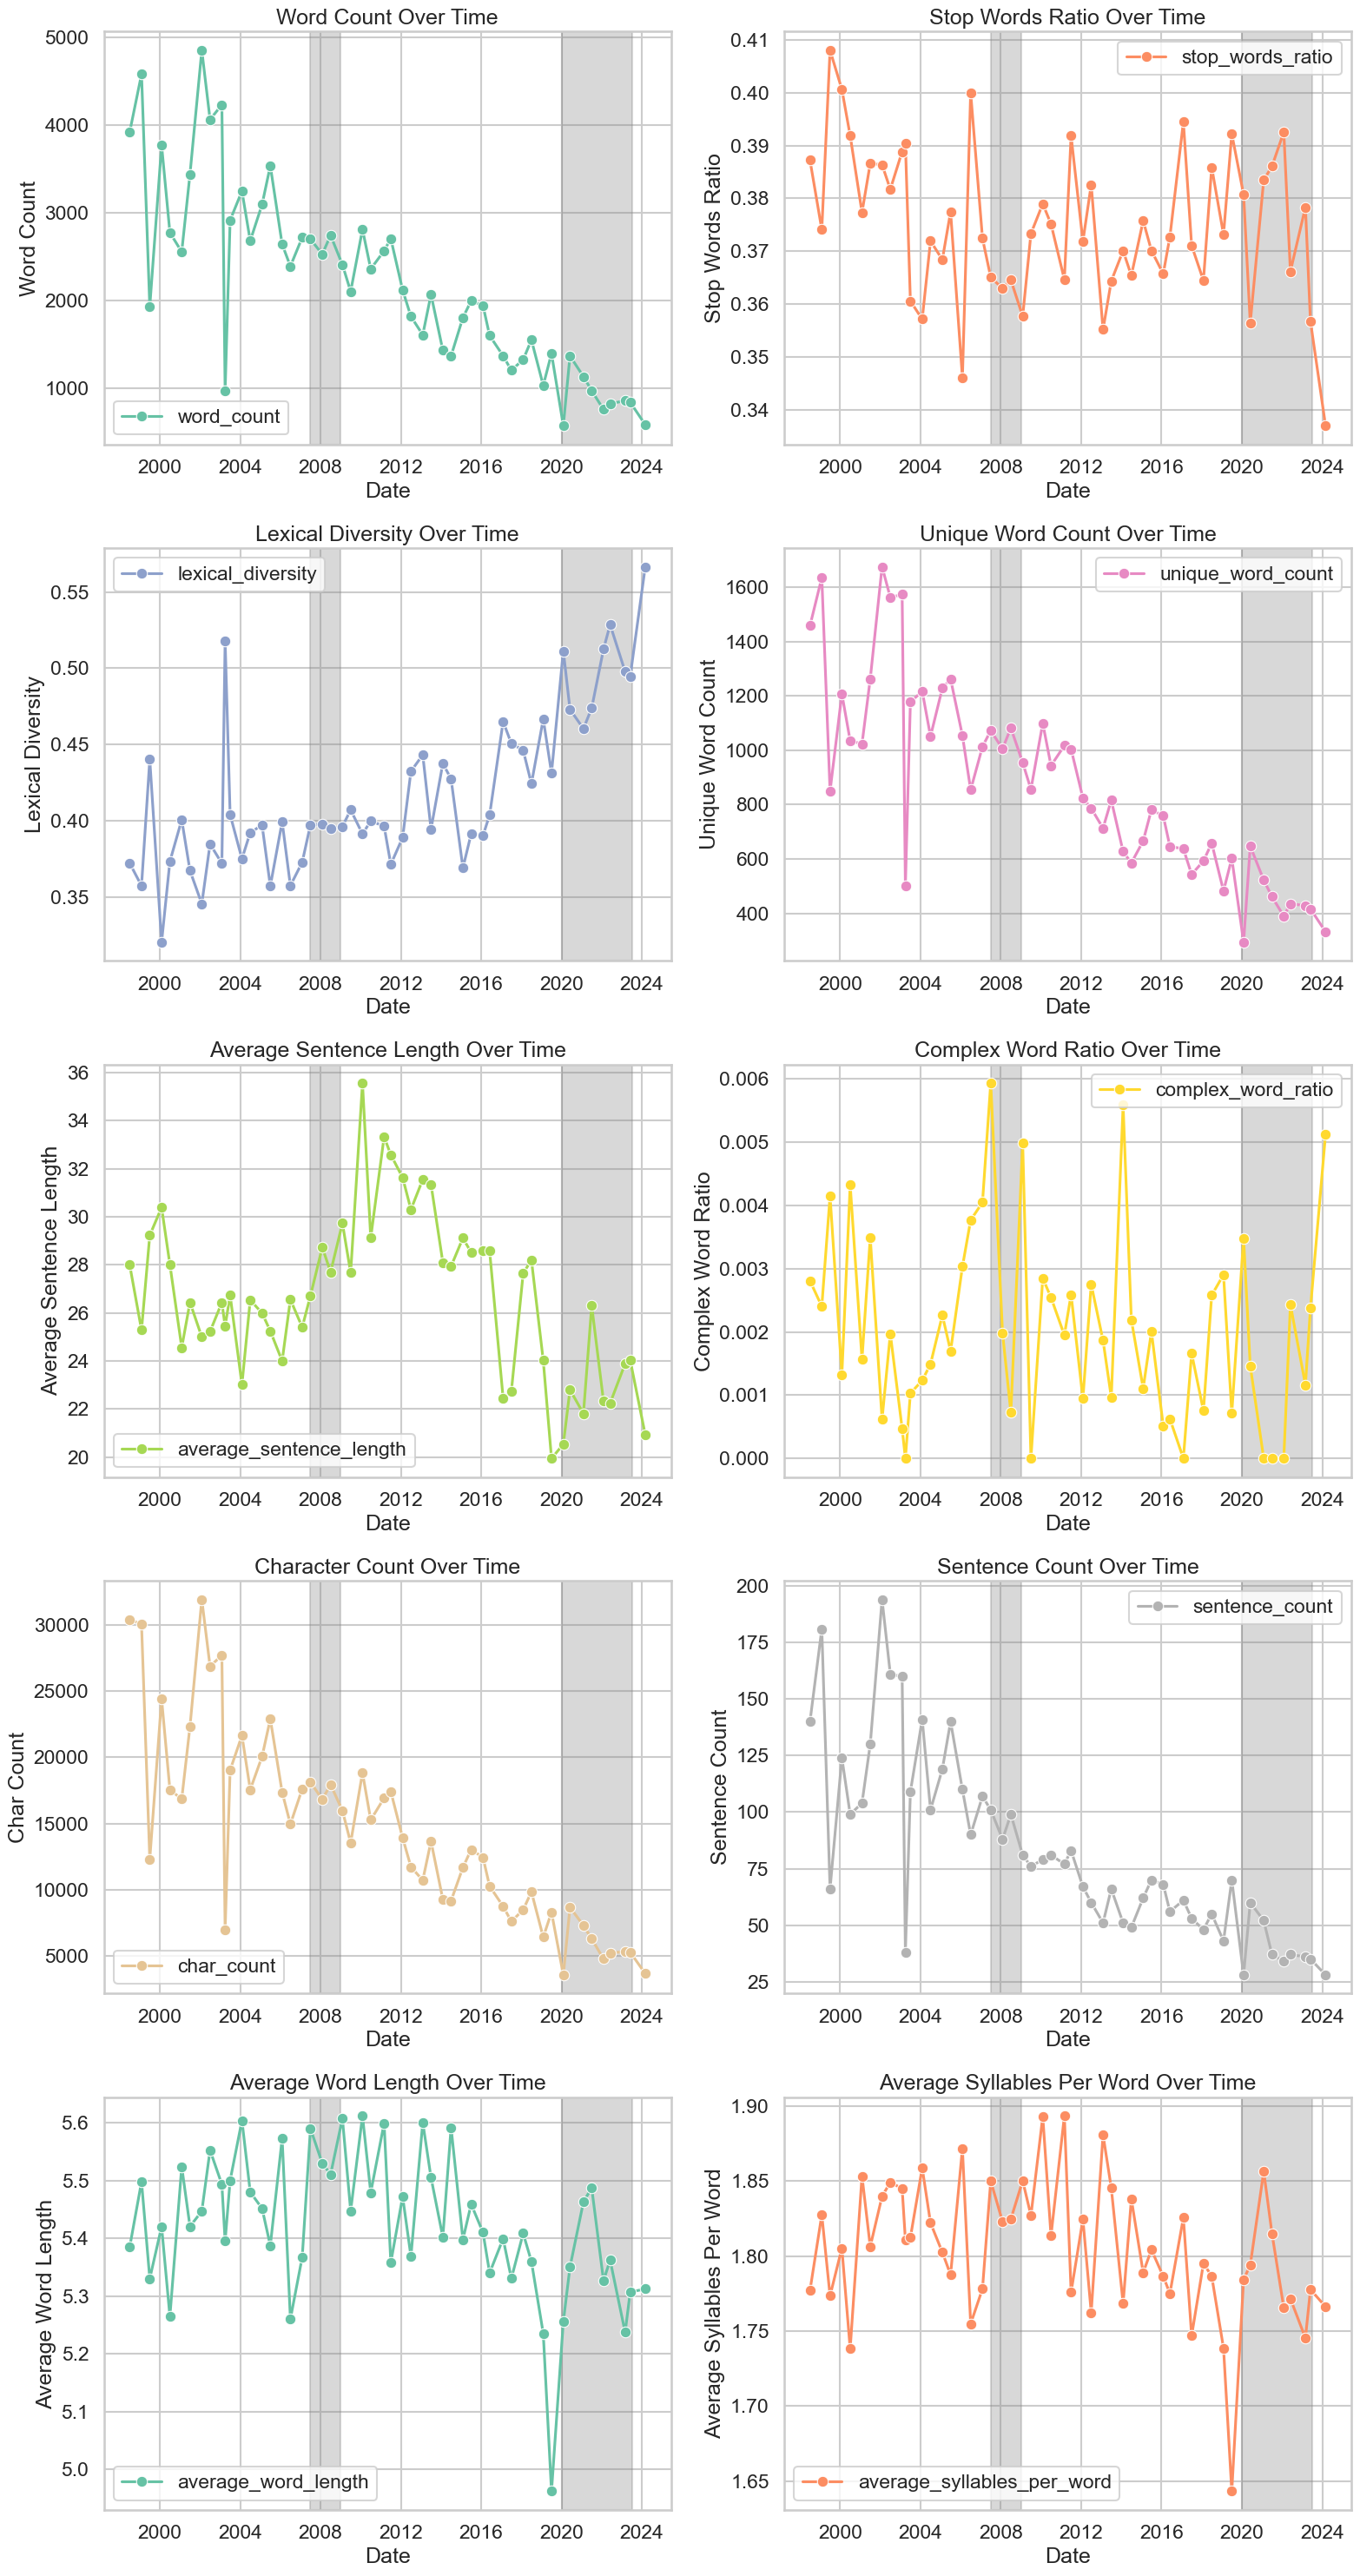

In [32]:
# Configure the style and context
sns.set(style="whitegrid", context="talk")

# Configure the figure size and axes
fig, axs = plt.subplots(5, 2, figsize=(16, 30))

# Use a Seaborn color palette
palette = sns.color_palette("Set2", 10)

# Data to plot
plot_data = [
    ("Word Count Over Time", "word_count", palette[0]),
    ("Stop Words Ratio Over Time", "stop_words_ratio", palette[1]),
    ("Lexical Diversity Over Time", "lexical_diversity", palette[2]),
    ("Unique Word Count Over Time", "unique_word_count", palette[3]),
    ("Average Sentence Length Over Time", "average_sentence_length", palette[4]),
    ("Complex Word Ratio Over Time", "complex_word_ratio", palette[5]),
    ("Character Count Over Time", "char_count", palette[6]),
    ("Sentence Count Over Time", "sentence_count", palette[7]),
    ("Average Word Length Over Time", "average_word_length", palette[8]),
    ("Average Syllables Per Word Over Time", "average_syllables_per_word", palette[9])
    ]

# Plotting each graph with additional features
for i, (title, column, color) in enumerate(plot_data):
    row, col = divmod(i, 2)
    sns.lineplot(data=df_raw, x="date", y=column, ax=axs[row, col], color=color, marker='o', label=column)
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel("Date")
    axs[row, col].set_ylabel(column.replace("_", " ").title())
    axs[row, col].grid(True)
    axs[row, col].legend(loc='best')

 # Add shaded areas for specified periods
    axs[row, col].axvspan(pd.to_datetime('2007-07-01'), pd.to_datetime('2009-01-01'), color='gray', alpha=0.3)
    axs[row, col].axvspan(pd.to_datetime('2020-01-01'), pd.to_datetime('2023-07-01'), color='gray', alpha=0.3)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

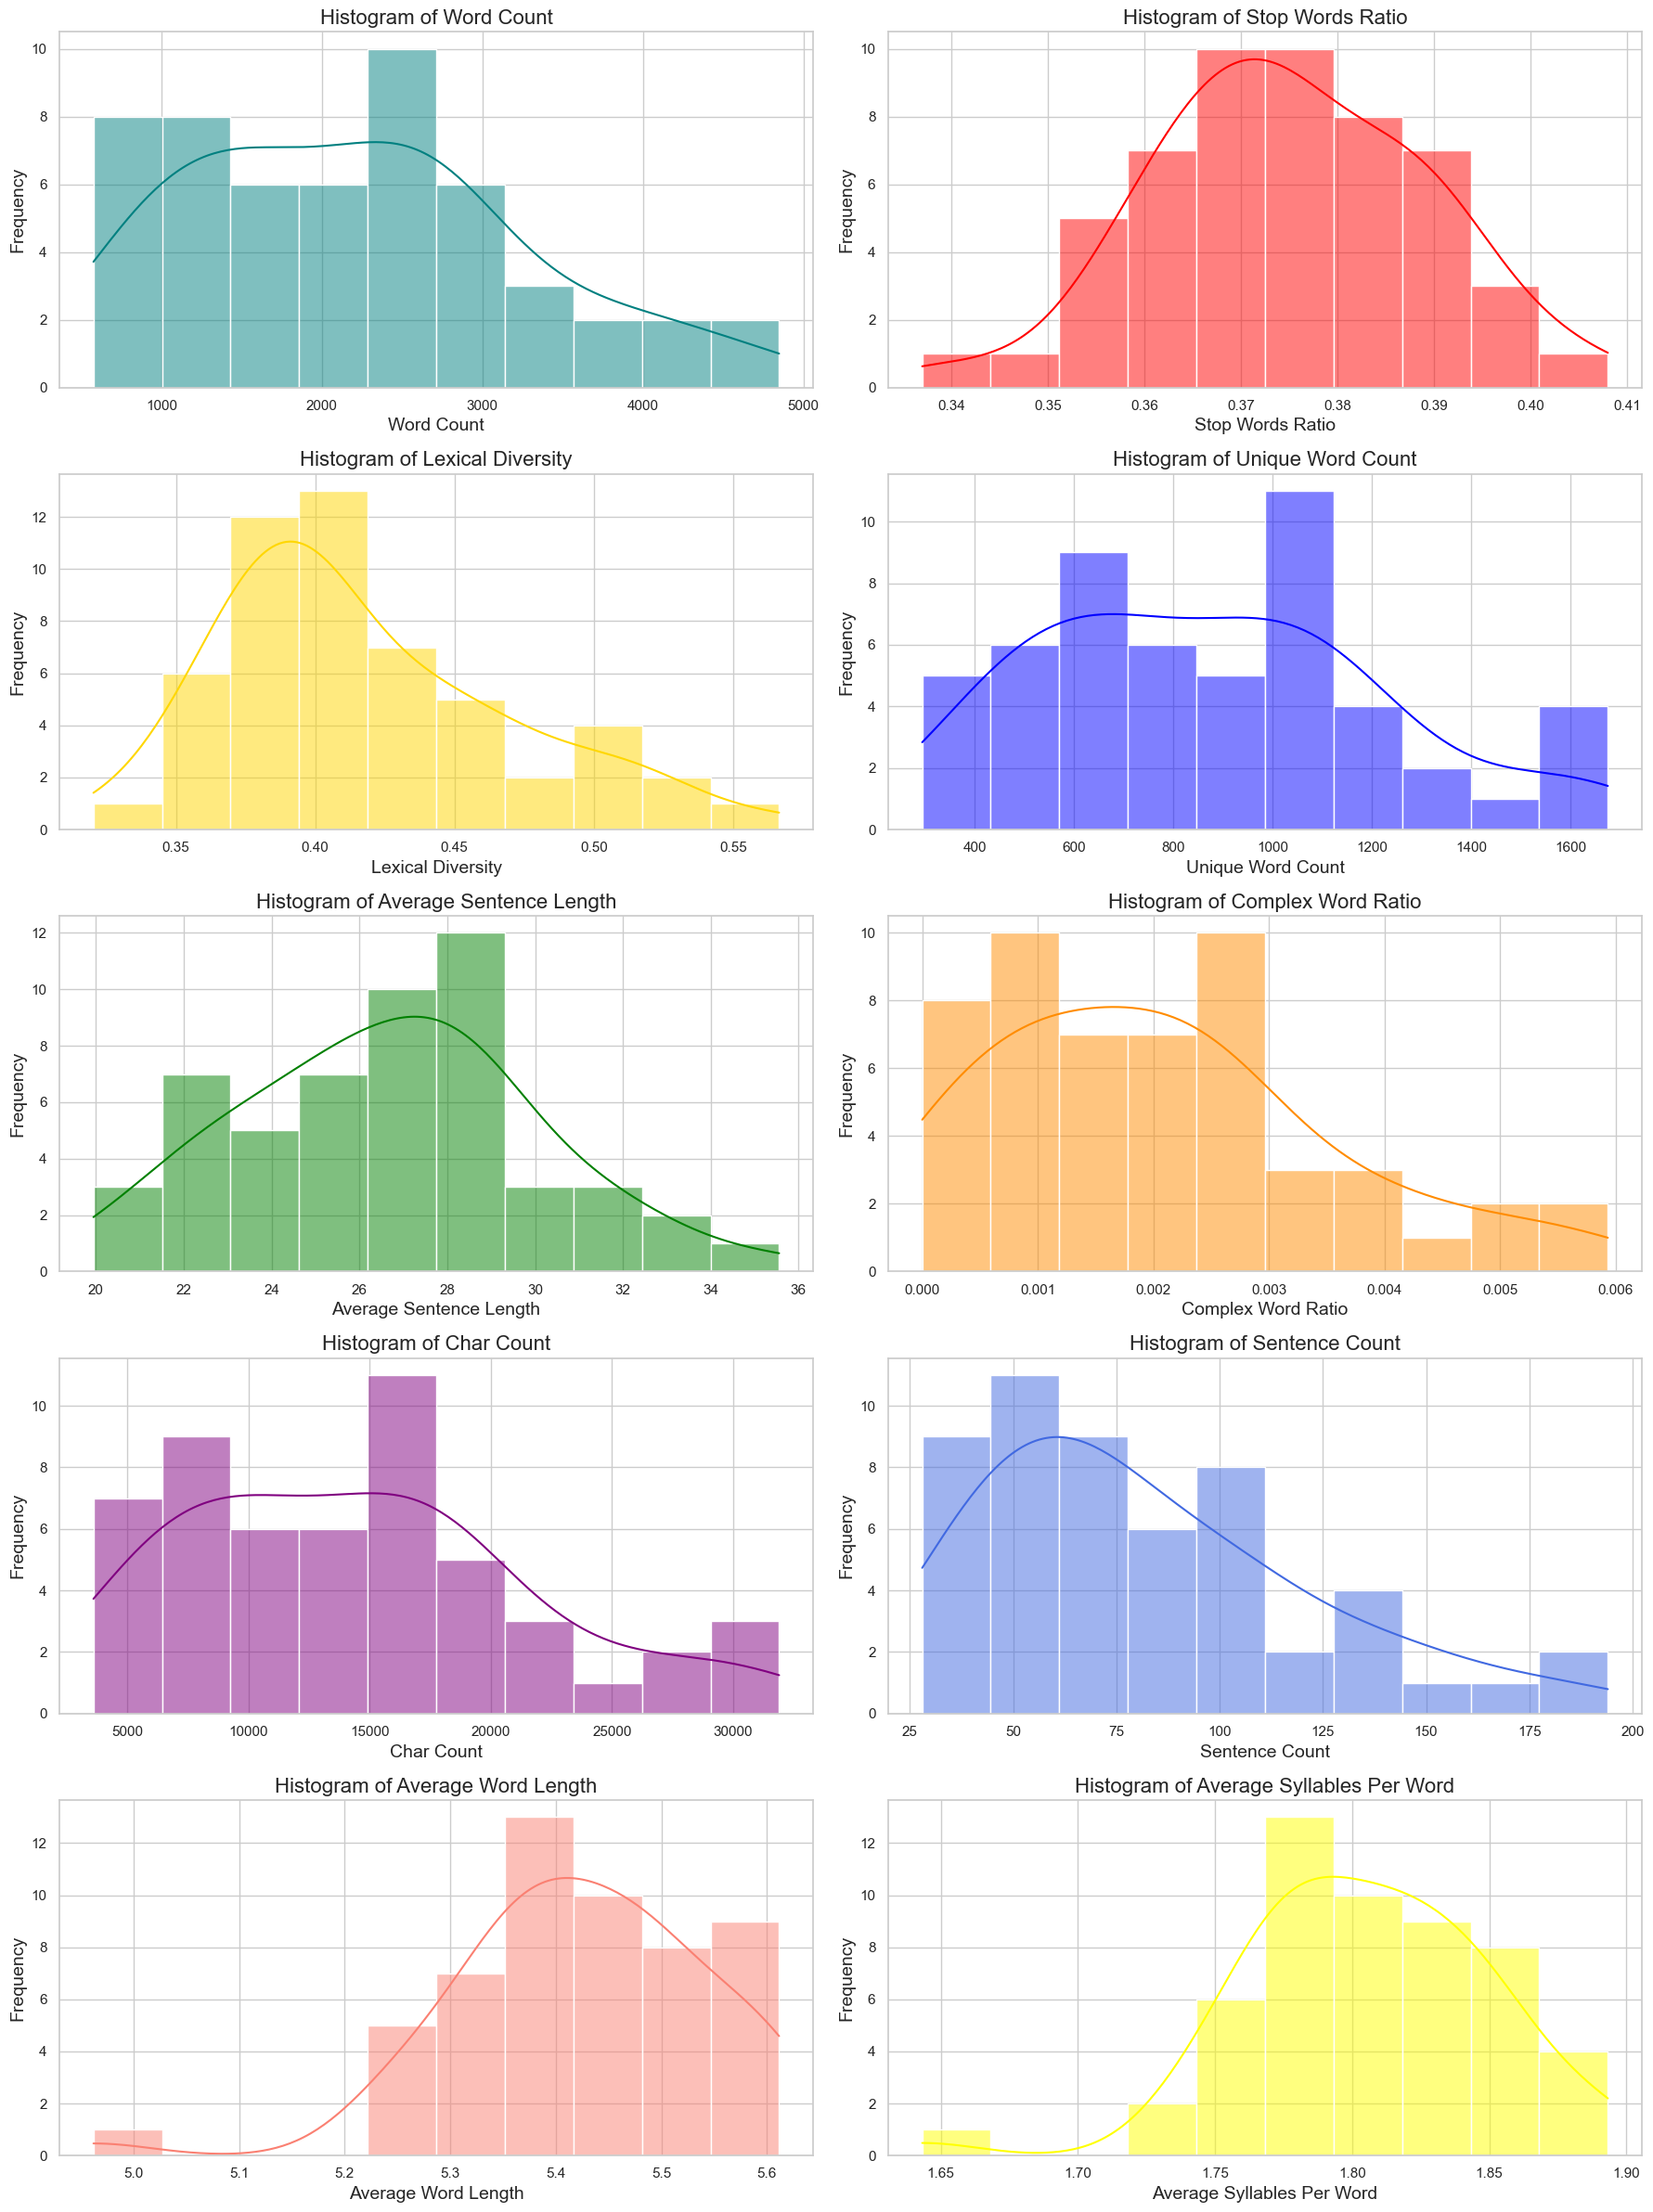

In [33]:
# Configure the style
sns.set(style="whitegrid")

# Colors for each histogram 
colors = [
    "teal", "red", "gold", "blue", "green", "darkorange", "purple", "royalblue", "salmon", "yellow"
    ]

# Plot histograms for all numerical variables
numerical_columns = [
    "word_count", "stop_words_ratio", "lexical_diversity", "unique_word_count", "average_sentence_length", "complex_word_ratio", "char_count", "sentence_count", "average_word_length",
    "average_syllables_per_word"
    ]

# Set up the matplotlib figure
plt.figure(figsize=(18, 24))
for i, (column, color) in enumerate(zip(numerical_columns, colors), 1):

    # Adjust the number of rows and columns as needed
    plt.subplot(5, 2, i)  
    sns.histplot(df_raw[column], bins=10, kde=True, color=color)
    plt.title(f"Histogram of {column.replace('_', ' ').title()}", fontsize=16)
    plt.xlabel(column.replace('_', ' ').title(), fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(True)

plt.tight_layout()
plt.show()

### **3. PREPARE AND CLEAN TEXTUAL DATA**

This section cleans the data so that is ready for analysis. The Monetary Policy Reports are pre-processed by excluding administrative details on the webpage to focus on the core of the text. In addition, several additional steps were undertaken to clean the data prior to estimating the tone of the minutes. This includes following steps to preprocess text data using NLTK. The process includes tokenisation, stopword removal, and lemmatization.

#### 3.1 Text Adjustments

In [34]:
# Remove hypthens and replace with an empty string
df_raw["text"] = df_raw["text"].str.replace("-", " ")

In [35]:
# Replace acrynoms with full words 
df_raw["text"] = df_raw["text"].str.replace("Federal Open Market Committee", "FOMC")
df_raw["text"] = df_raw["text"].str.replace("gross domestic product", "GDP")
df_raw["text"] = df_raw["text"].str.replace("consumer price index", "CPI")
df_raw["text"] = df_raw["text"].str.replace("personal consumption expenditures", "PCE")

In [36]:
# Replace r/n with empty string
df_raw["text"] = df_raw["text"].str.replace(r"[\r\n]+", " ", regex=True)

#### 3.2 Convert Text to Lowercase

Converting the text to lowercase significantly helps with consistency of the output. E.g. we don't want python to read Laptop, LAPTOP, and laptop as three separate words.

In [37]:
# Convert text to lowercase 
df_raw["text"] = df_raw["text"].str.lower()

#### 3.3 Remove Punctuation

Punction removal helps to eliminate unneccessary symobls and text to make it more clean and simple. 

In [38]:
# Remove punctuation from text 
df_raw["text"] = df_raw["text"].str.replace(r"[^\w\s]", " ", regex = True)

#### 3.4 Remove Stopwords

A stopword is a commonly used word such as ("the", "a", "an" or "in") that does not have any reported meaning. By filtering out, enhances textual analysis and computational efficiency, plus drawing attention to more important words.

In [39]:
import nltk
from nltk.corpus import stopwords

In [40]:
nltk.download("stopwords")

# Create list of stopwords from english stopword list
stop_words = set(stopwords.words("english"))

print(stop_words)

# Remove stopwords from text
df_raw["text"] = df_raw["text"].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))

{'only', 'mustn', 'that', 'needn', 'here', 'until', "should've", "wasn't", 'herself', "mustn't", 'few', 'ain', "isn't", 'being', 'yours', 'you', 'off', "shouldn't", 'aren', "she's", 'been', 'most', "you're", "aren't", 'who', 'did', 'any', 'these', 'so', 'out', 'they', 'himself', 'down', 'o', "hasn't", 'between', 'didn', 'what', 'ourselves', 'itself', 'had', 'isn', 'ma', 'were', 'it', 'than', 'yourself', 'doesn', "mightn't", 'just', 'from', 'its', 'with', 'me', 'an', 'now', 'we', "weren't", 'was', 'doing', 'above', 'hers', 'the', 'be', 'where', 'against', 'to', 'during', 'of', 'our', 'under', 'when', 'or', 'hasn', 'shan', 'theirs', "shan't", 'll', 'there', 'don', "haven't", 'as', 'wouldn', 'their', 'some', 'before', 'couldn', 'shouldn', 'again', 'through', 'myself', 's', 't', 'my', "doesn't", 'wasn', 'them', 'once', 'other', 'his', 'themselves', 'all', 'nor', 'own', 'too', 'below', 'while', 'whom', "couldn't", 'over', "you've", "didn't", 'your', 'for', 'in', 'her', "wouldn't", "hadn't",

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eland\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 3.5 Tokenisation

In [41]:
from nltk import pos_tag, word_tokenize
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eland\AppData\Roaming\nltk_data...


True

In [42]:
# Function that tokenises words 
def tokenize_sentence(sentence):
    return nltk.word_tokenize(sentence) # use NLTK to split text into individual words (i.e. tokens)

df_raw["text"] = df_raw["text"].apply(tokenize_sentence)

#### 3.6 Lemmatisation

Lemmatisation reduces words to their base or root form, making the text more standardized and easier to analyse.

In [43]:
from nltk.stem import WordNetLemmatizer

In [44]:
# Set word lemmatizer
lemmatizer = WordNetLemmatizer()

# Function that lemmatises words
def lemmatize_words(word_list):
    # Tag each word with its part of speech (POS)
    tagged_words = pos_tag(word_list)
    # Lemmatize each word based on its POS tag
    return [lemmatizer.lemmatize(w, pos=pos[0].lower()) if pos[0].lower() in ['a', 'r', 'n', 'v'] else lemmatizer.lemmatize(w) for w, pos in tagged_words]

# Lemmatize each word in tokenized column for each row
df_raw["text"] = df_raw["text"].apply(lemmatize_words)

#### 3.7 Create Final Dataframe

In [45]:
# Create new dataset of cleaned text data
df_clean = df_raw[["text"]]

### **4. ANALYSIS CLEANED TEXTUAL DATA**

This section provides further analysis of the tokenised and cleaned textual data. In particular, it explores the frequency of words graphically. 

In [46]:
df_clean.head()

,text
date,
1998-07-01,"[another, exemplary, performance, 1997, four, ..."
1999-02-01,"[past, year, perform, admirably, despite, chal..."
1999-07-01,"[1999, exceptional, year, american, economy, c..."
2000-02-01,"[american, economy, grow, 4, percent, 1999, su..."
2000-07-01,"[confront, complex, set, challenge, judge, sta..."


#### 4.1 Word Frequencies
Taking the text of all the columns, we join and remove some repeated words which have no economic sense, then we count them and find the frequency in which they appear, with wordcloud, matplotlib and seaborn we plot to visualize which are the most repeated words. 

In [47]:
# Create a copy of the DataFrame
df_clean_copy = df_clean.copy()

# Define the words to remove
words_to_remove = [
    "member", "note", "would", "also", "around", "board", "rate", "year", "month", "quarter", "time", "however", "march", "september", "well", "december", "non", "two", "may", "3", "term", "2", "1"]
# Remove the words from the "text" column

def remove_words(word_list):
    return [word for word in word_list if word.lower() not in words_to_remove]
df_clean_copy["text"] = df_clean_copy["text"].apply(remove_words)

In [48]:
from collections import Counter
# Convert lists of words to strings
df_clean_copy["text"] = df_clean_copy["text"].apply(lambda x: ' '.join(x))

# Combine all text for word frequency analysis
all_text = ' '.join(df_clean_copy["text"])

word_counts = Counter(all_text.split())
common_words = word_counts.most_common(20)

# Word frequency DataFrame
word_freq_df = pd.DataFrame(common_words, columns=["Word", "Frequency"])

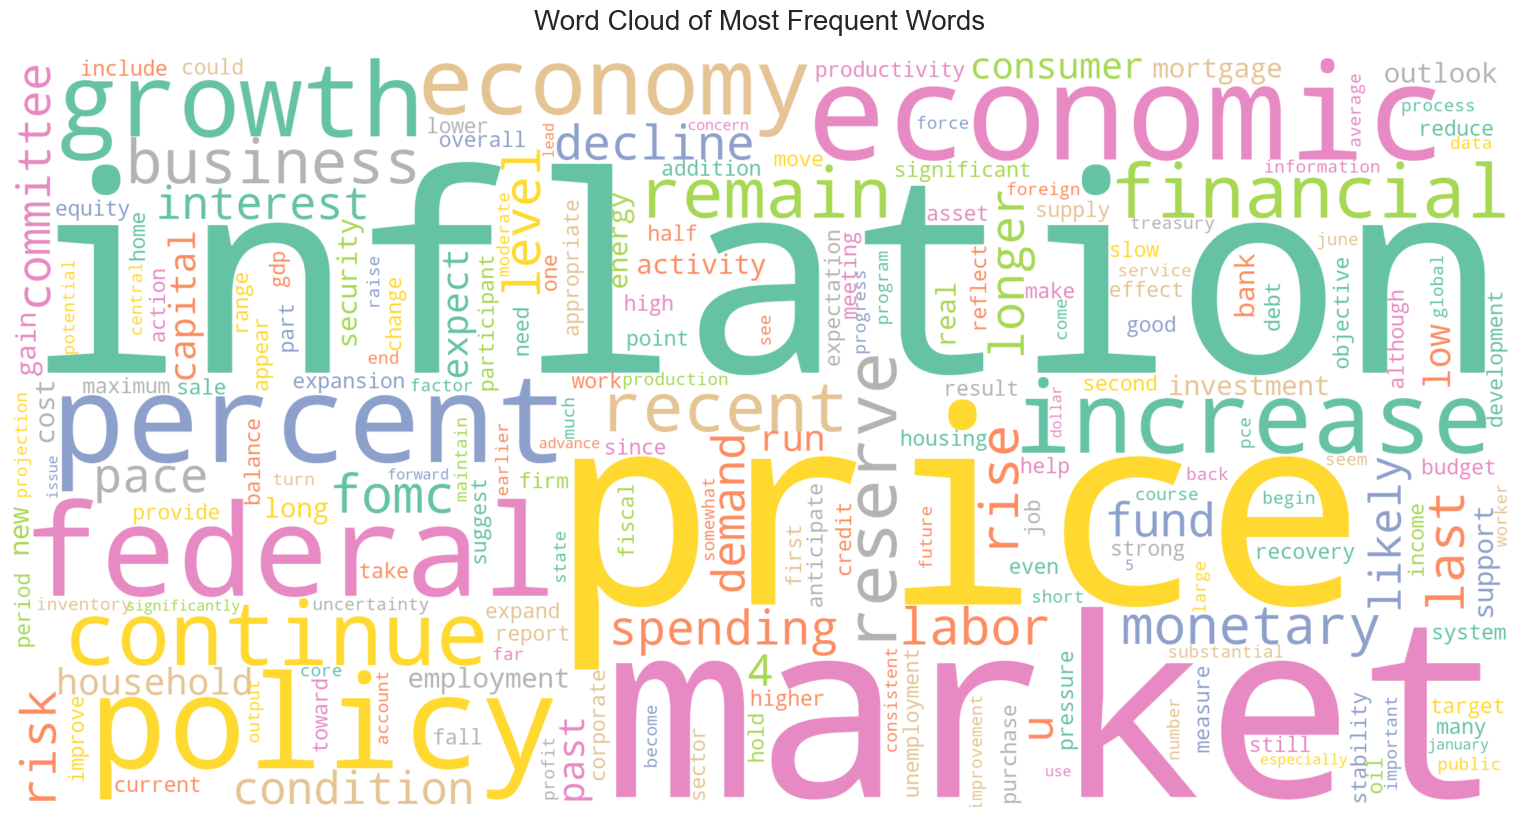

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a color function based on the seaborn color palette
palette = sns.color_palette("Set2", 10)
color_palette = sns.color_palette(palette).as_hex()

# Enhanced color function to cycle through the color palette
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return color_palette[np.random.randint(len(color_palette))]
    
# Create a wordcloud with the custom color function and enhanced settings
wordcloud = WordCloud(width=1200, height=600,
                      background_color="white",
                      max_words=200,
                      contour_color="steelblue",
                      contour_width=1,
                      color_func=color_func,
                      prefer_horizontal=0.5, 
                      scale=2, 
                      relative_scaling=0.5,  
                      collocations=False,  
                      random_state=42).generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequent Words", fontsize=20, pad=20)
plt.tight_layout(pad=0)
plt.show()


In [50]:
num_words = len(word_counts)
print("Number of words in the word cloud:", num_words)

Number of words in the word cloud: 4315


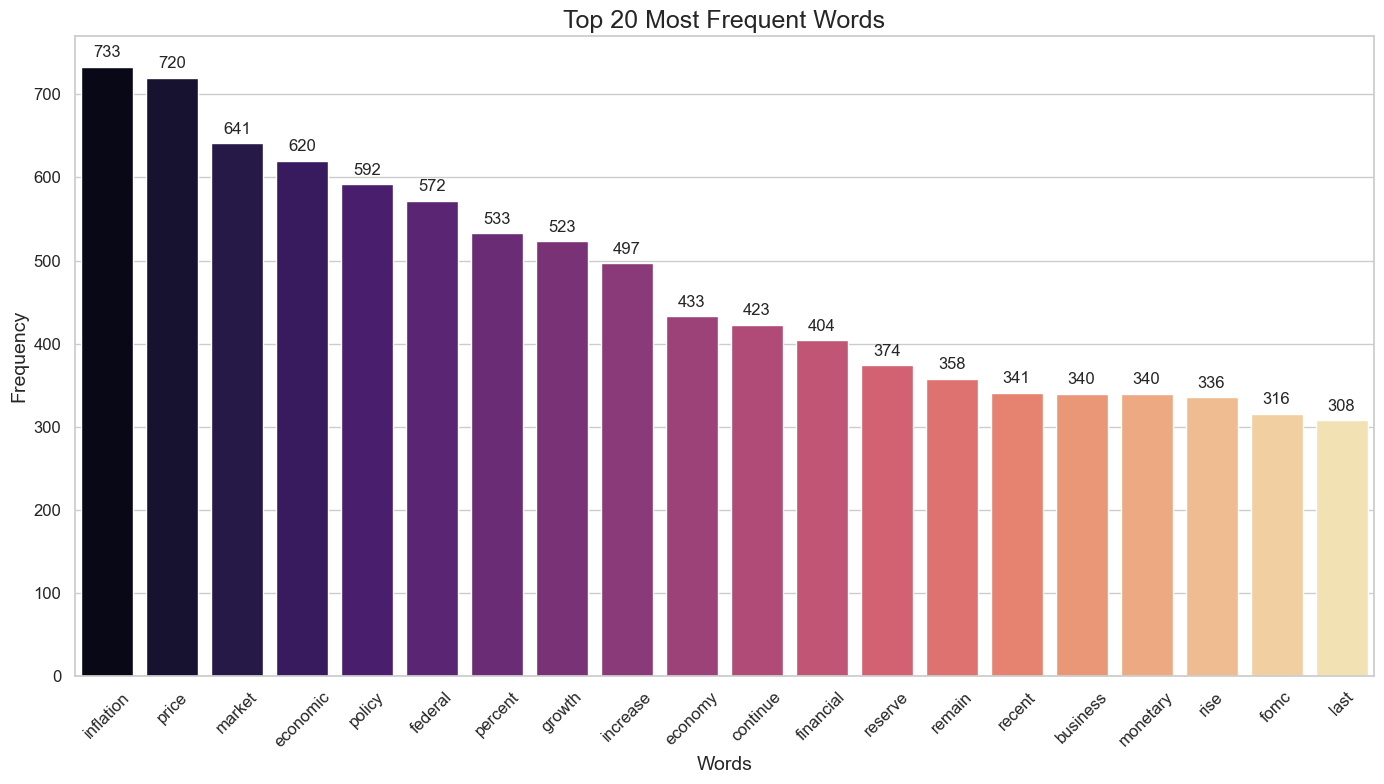

In [51]:
# Create the bar chart
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(x="Word", y="Frequency", data=word_freq_df, palette="magma", hue="Word", dodge=False)

# Add value labels on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), ".0f"), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = "center", va = "center", 
                      xytext = (0, 10), 
                      textcoords = "offset points")

# Customize the plot
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Top 20 Most Frequent Words", fontsize=18)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


### **5. CREATE COMMUNICATION VARIABLE**

This section converts the qualitative textual data to a quantitative measure. A lexicon-based method is used which relies on a pre-defined list of words called lexicons or dictionaries, each associated with sentiment scores ranging from positive to negative. In particular, the Loughran and McDonald (2011) financial sentiment dictionary is employed in this study as it is the most suitable approach for classifying financial and economic texts.

The sentiment score is calculated by subtracting the count of negative words from the count of positive words, and then dividing by the total count of positive and negative words. Mathematically, this is represented as:

$$ \text{Tone} = \frac{N_{\text{pos}} - N_{\text{neg}}}{N_{\text{pos}} + N_{\text{neg}}} $$

Where:
- $N_{\text{pos}}$ is the number of words in the minutes that are classified as positive according to the Loughran-McDonald sentiment dictionary.
- $N_{\text{neg}}$ is the number of words that are classified as negative.

The measure of tone is bounded between [-1:1]. A positive value of the tone measure reflects some optimism in the language used, while a negative value reflects some pessimism.

| Scale    | Number of Words | Sample Words                                                                                                               |
|----------|------------------|----------------------------------------------------------------------------------------------------------------------------|
| Negative | 2,335            | adverse, caution, challenge, collapse, crisis, decline, deteriorate, difficult, diminish, exacerbate, failure, liquidated, loss, negative, punishes, recession, severe, slowdown, stagnate, unemployed |
| Positive | 354              | achieve, advantage, attain, boom, constructive, efficient, enhance, favourable, gained, highest, improve, leading, optimistic, positive, profitable, progress, rebound, stabilize, strengthen, strong |

*Source: Loughran and McDonald (2011)*

In [52]:
# LM is the Loughran and McDonald Financial Sentiment Dictionaries lexicon for sentiment analysis
from pysentiment2 import lm 

In [53]:
# Define a function to calculate polarity score for a list of tokens
def calculate_polarity(tokens):
    # Initialize the LM lexicon
    lexicon = lm.LM()
    # Calculate polarity score using the lexicon
    sentiment = lexicon.get_score(tokens)["Polarity"]
    return sentiment

# Apply the function to each row in the 'tokens' column and assign the result to a new column
df_clean["comm"] = df_clean["text"].apply(calculate_polarity)

C:\Users\eland\AppData\Local\Temp\ipykernel_1600\2772049448.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["comm"] = df_clean["text"].apply(calculate_polarity)


In [54]:
df_clean.head()

,text,comm
date,,
1998-07-01,"[another, exemplary, performance, 1997, four, ...",-0.315789
1999-02-01,"[past, year, perform, admirably, despite, chal...",-0.400000
1999-07-01,"[1999, exceptional, year, american, economy, c...",-0.513513
2000-02-01,"[american, economy, grow, 4, percent, 1999, su...",-0.115789
2000-07-01,"[confront, complex, set, challenge, judge, sta...",-0.413333


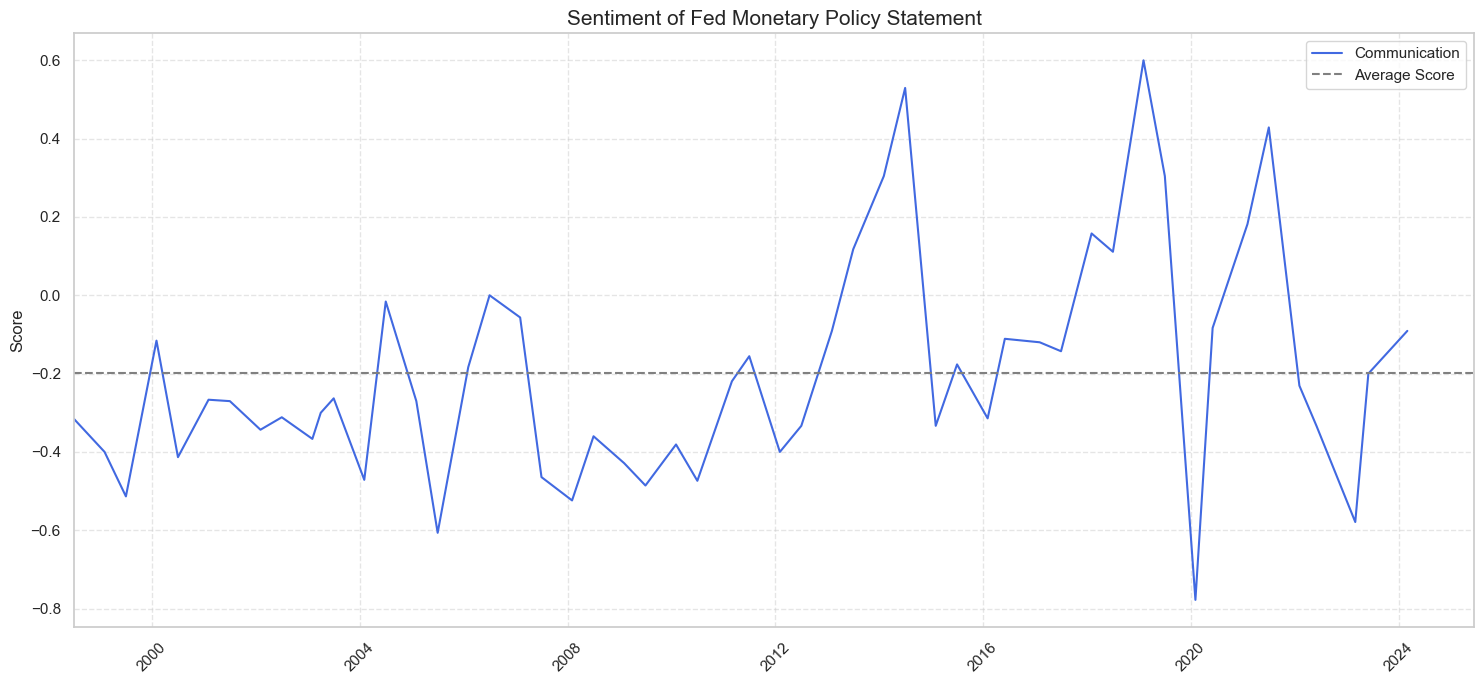

In [55]:
# Calculate the average score
avg_comm = df_clean["comm"].mean()

# Plot rolling average with 
plt.figure(figsize=(15, 7))
plt.plot(df_clean.index, df_clean["comm"], label = "Communication", linestyle = "-", color = "royalblue")
plt.axhline(y = avg_comm , color = "grey", linestyle = "--", label = "Average Score")

plt.ylabel("Score", fontsize=12)
plt.title("Sentiment of Fed Monetary Policy Statement", fontsize=15)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(df_clean.index[0], )
plt.tight_layout()

# Add shaded areas for specified periods
axs[row, col].axvspan(pd.to_datetime("2007-07-01"), pd.to_datetime("2009-01-01"), color="gray", alpha=0.3)
axs[row, col].axvspan(pd.to_datetime("2020-01-01"), pd.to_datetime("2023-07-01"), color="gray", alpha=0.3)

plt.legend()
plt.show()

### **6. IMPORT MACROECONOMIC DATA**

This section imports the macroeconomic variables using an API key from FRED. These data are then converted from a quarterly to a semi-annual basis, consistent with textual data. The inflation and output gaps are next calculated. The inflation gap is calculated as the absolute difference between contemporaneous inflation and the Fed's 2% longer-run inflation target. The output gap the absolute difference between the logarithmic level of real GDP and its trend value, estimated using the Hodrick-Prescott (HP) filter.

These data are then merged with the communication data into the single dataframe.

In [56]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas_datareader import fred
import matplotlib.pyplot as plt

#### 6.1 Import Macroeconomic Data

In [57]:
# Grab data using FredReader
data = fred.FredReader(symbols=["GDPC1", #real GDP, $USb, quarterly, SA
                                "MEDCPIM159SFRBCLE"], #CPI, yearly change, quarterly, SA
                       start="1900-01-01", 
                       end=None).read()

# Save the data to a CSV file
data.to_csv("macro_vars.csv")

# Read the data back from the CSV file to a DataFrame
df_macro_vars = pd.read_csv("macro_vars.csv")

# Check data has imported correctly
print(df_macro_vars.tail())

           DATE      GDPC1  MEDCPIM159SFRBCLE
628  2023-12-01        NaN           4.922162
629  2024-01-01  22768.866           4.851557
630  2024-02-01        NaN           4.578594
631  2024-03-01        NaN           4.553789
632  2024-04-01        NaN           4.476036


In [58]:
# Create a list to rename variables
new_column_names = ["date", "GDP", "CPI"]

# Rename the columns
df_macro_vars = df_macro_vars.rename(columns=dict(zip(df_macro_vars.columns, new_column_names)))

In [59]:
# Set date as datetime format and set as index
df_macro_vars["date"] = pd.to_datetime(df_macro_vars["date"])
df_macro_vars.set_index("date", inplace=True)

# Convert data to semi-annual basis, consistent with textual data 
GDP = df_macro_vars["GDP"].resample("6M").mean()
CPI = df_macro_vars["CPI"].resample("6M").mean()

# Create new dataframe, with macro data on semi-annual basis
df_macro_vars = pd.DataFrame({"GDP": GDP, "CPI": CPI})

# Convert GDP to log level
df_macro_vars["GDP"] = np.log(df_macro_vars["GDP"])

# Remove final observation as no GDP data 
df_macro_vars = df_macro_vars[df_macro_vars.index != pd.to_datetime("2024-07-31")]

In [60]:
df_macro_vars.tail()

,GDP,CPI
date,,
2022-01-31,9.989355,3.308759
2022-07-31,9.988731,5.387641
2023-01-31,10.001120,6.768873
2023-07-31,10.014940,6.602468
2024-01-31,10.031180,5.199520


#### 6.2 Create Inflation and Output Gap

In [61]:
# Create inflation gap, 2 represents 2% inflation target of the Fed
df_macro_vars["CPI_gap"] = df_macro_vars["CPI"] - 2

# Apply the HP filter to the 'GDP' column with the adjusted lambda value
cycle, trend = sm.tsa.filters.hpfilter(df_macro_vars["GDP"], lamb= 1600)

# Calculate the GDP gap
df_macro_vars["GDP_gap"] = df_macro_vars["GDP"] - trend

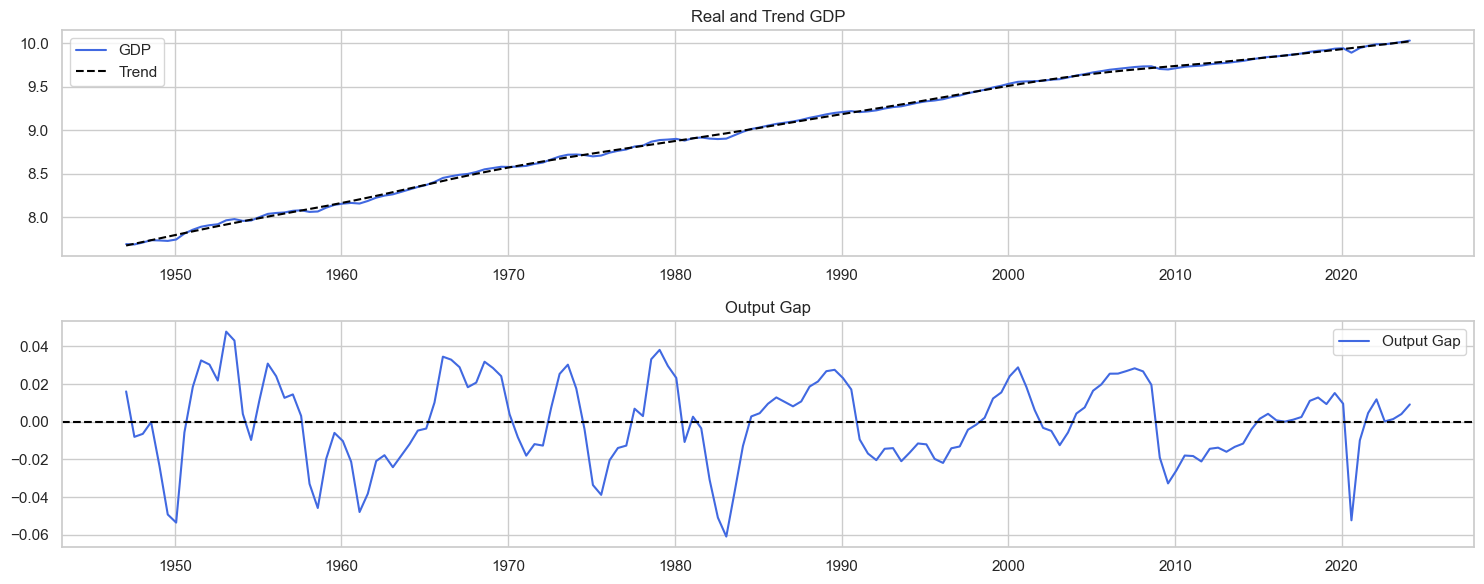

In [62]:
# Visualise Output Gap
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(df_macro_vars.index, df_macro_vars["GDP"], label = "GDP", color = "royalblue")
plt.plot(df_macro_vars.index, trend, label = "Trend", linestyle = "--", color = "black")
plt.title("Real and Trend GDP")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df_macro_vars.index, df_macro_vars["GDP_gap"], label = "Output Gap", color = "royalblue")
plt.axhline(0, linestyle = "--", color = "black")  # Adding zero line for reference
plt.title("Output Gap")
plt.legend()

plt.tight_layout()
plt.show()

#### 6.3 Create Final Dataframe 

This section merges the communication measure and the macroeconomic variables.

In [63]:
# Function that turns date to 1 rather 31 day
def date_adj(date):
    if date.month == 1:
        return pd.Timestamp(year=date.year, month=1, day=1)
    elif date.month == 7:
        return pd.Timestamp(year=date.year, month=7, day=1)
    else:
        raise ValueError("Error")

# Apply the function to dataframe
df_macro_vars.index = df_macro_vars.index.map(date_adj)

# Function to change date from Jan to Feb
def change_month(date):
    if date.month == 1:
        return pd.Timestamp(year=date.year, month=2, day=1)
    else:
        return date

#Apply the function to dataframe
df_macro_vars.index = df_macro_vars.index.map(change_month)

In [64]:
# Start macroeconomic dataframe from 1998-07-01	to be consistent with communication indicies
df_macro_vars = df_macro_vars[df_macro_vars.index >= "1998-07-01"]

In [65]:
# Function to change date from Mar to Feb
def change_month_2(date):
    if date.month == 3:
        return pd.Timestamp(year=date.year, month=2, day=1)
    else:
        return date

# Apply the function to the index
df_clean.index = df_clean.index.map(change_month_2)

In [66]:
# Merge the DataFrames on the date column
df_final = pd.merge(df_macro_vars, df_clean, on="date", how="inner")

# Drop the text column from dataframe
df_final = df_final.drop(columns=["text"])

### **7. DESCRIPTIVE STATISTICS**

This section provides descriptive statistics for each variable of interest.

#### 7.1 Summary Table

In [67]:
df_final.tail()

,GDP,CPI,CPI_gap,GDP_gap,comm
date,,,,,
2021-02-01,9.945461,2.533994,0.533994,-0.009888,0.181818
2021-07-01,9.970974,2.226577,0.226577,0.004598,0.428571
2022-02-01,9.989355,3.308759,1.308759,0.011903,-0.230769
2023-02-01,10.001120,6.768873,4.768873,0.001427,-0.578947
2024-02-01,10.031180,5.199520,3.199520,0.009189,-0.090909


#### 7.2 Density charts 

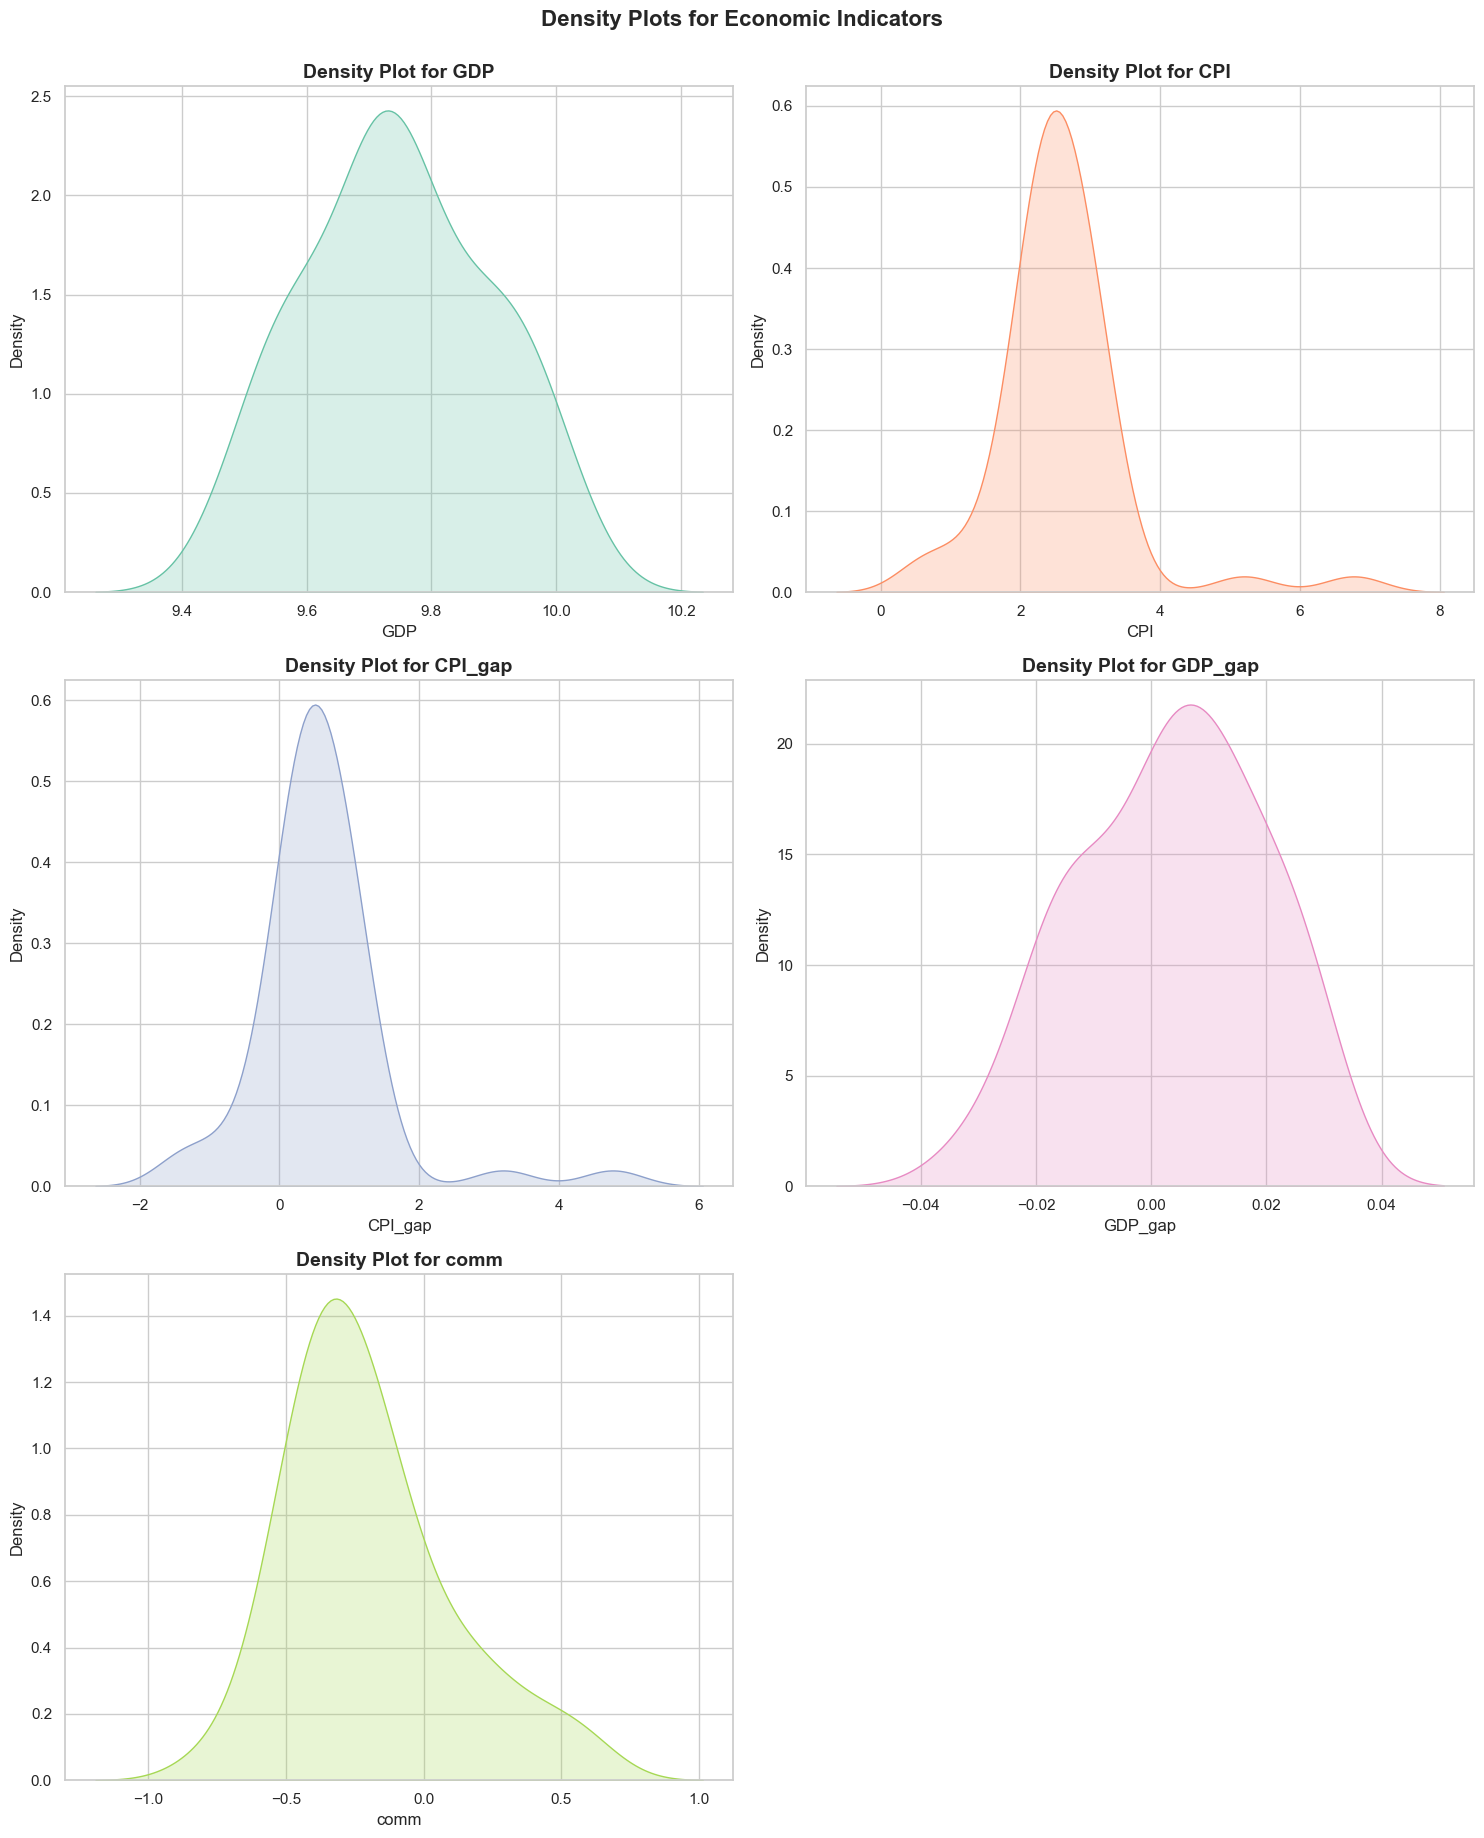

In [68]:
# Set style of the plots
sns.set(style="whitegrid")

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))

# List of columns to plot
columns_to_plot = ["GDP", "CPI", "CPI_gap", "GDP_gap", "comm"]

# Create a custom palette 
palette = sns.color_palette("Set2", len(columns_to_plot))

# Iterate over the columns and axes to create density plots
for ax, column, color in zip(axes.flat, columns_to_plot, palette):
    sns.kdeplot(df_final[column], fill=True, ax=ax, color=color)
    ax.set_title(f"Density Plot for {column}", fontsize=14, fontweight='bold')
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.grid(True)

# Hide the empty subplot
fig.delaxes(axes[2, 1])

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Add a main title for all subplots
fig.suptitle("Density Plots for Economic Indicators", fontsize=16, fontweight='bold', y=1.02)

plt.show()

#### 7.3 Correlation Analysis

In [69]:
from scipy.stats import pearsonr

In [70]:
# Correlation matrix
correlation_matrix = df_final.corr()

# Round the correlation matrix to 4 decimal places
correlation_matrix.round(4)

,GDP,CPI,CPI_gap,GDP_gap,comm
GDP,1.0000,0.2730,0.2730,-0.0797,0.3952
CPI,0.2730,1.0000,1.0000,0.3438,-0.1374
CPI_gap,0.2730,1.0000,1.0000,0.3438,-0.1374
GDP_gap,-0.0797,0.3438,0.3438,1.0000,0.0016
comm,0.3952,-0.1374,-0.1374,0.0016,1.0000


In [71]:
# Define the function to calculate Pearson correlation coefficient and its significance
def pearsonr_sig(x, y):
    corr, p_value = pearsonr(x, y)
    return corr, p_value

# Create a correlation matrix
correlation_matrix = df_final.corr()

# Create an empty matrix to store correlation coefficients and p-values
corr_with_p_values = np.empty((correlation_matrix.shape[0], correlation_matrix.shape[1]), dtype=object)

# Iterate through each pair of variables
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        # Calculate Pearson correlation coefficient and its p-value
        corr_with_p_values[i, j] = pearsonr_sig(df_final.iloc[:, i], df_final.iloc[:, j])

# Round the correlation matrix to 4 decimal places
correlation_matrix_rounded = correlation_matrix.round(4)

# Print the rounded correlation matrix
print("Correlation Matrix with Pearson Correlation Coefficients:")
print(correlation_matrix_rounded)
print("\n")

Correlation Matrix with Pearson Correlation Coefficients:
            GDP     CPI  CPI_gap  GDP_gap    comm
GDP      1.0000  0.2730   0.2730  -0.0797  0.3952
CPI      0.2730  1.0000   1.0000   0.3438 -0.1374
CPI_gap  0.2730  1.0000   1.0000   0.3438 -0.1374
GDP_gap -0.0797  0.3438   0.3438   1.0000  0.0016
comm     0.3952 -0.1374  -0.1374   0.0016  1.0000




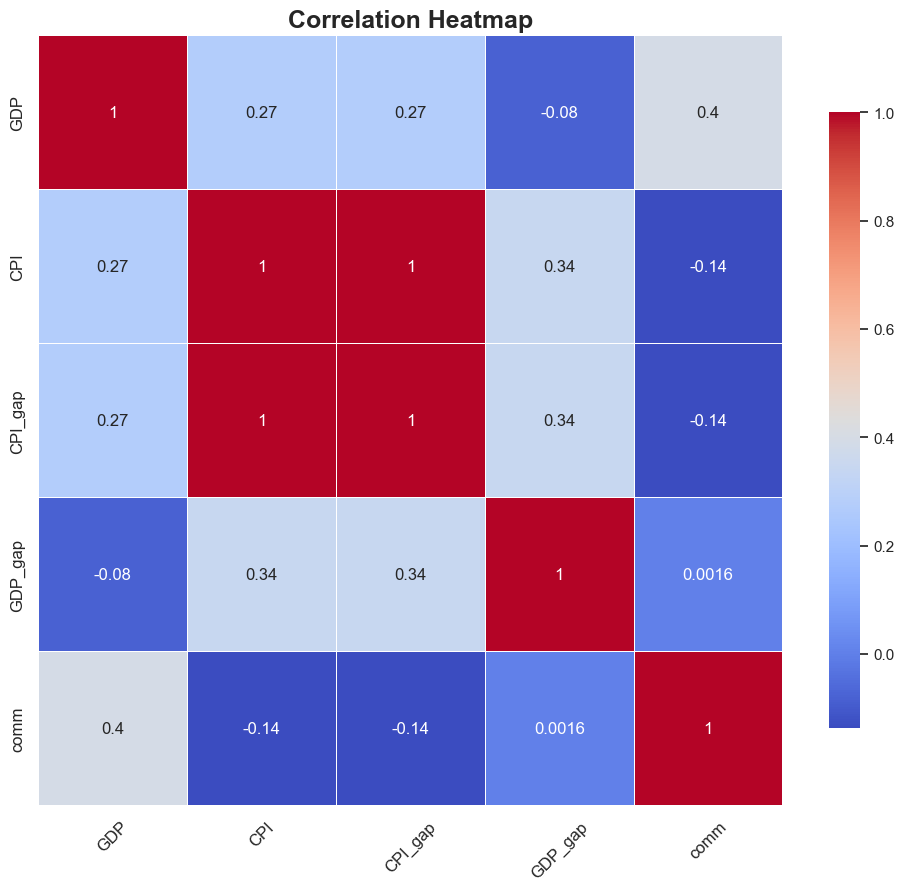

In [72]:
columns_to_plot = ["GDP", "CPI", "CPI_gap", "GDP_gap", "comm"]
df_final_filtered = df_final[columns_to_plot]

# Set a style
sns.set(style="whitegrid")

# Heatmap of Correlations
def plot_heatmap(df):
    plt.figure(figsize=(12, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title("Correlation Heatmap", fontsize=18, fontweight="bold")
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.show()

# Plot heatmap
plot_heatmap(df_final_filtered)


#### 7.4 Descriptive Statistics Visualizations (Box Plots, Violin Plots, Bar Plots)

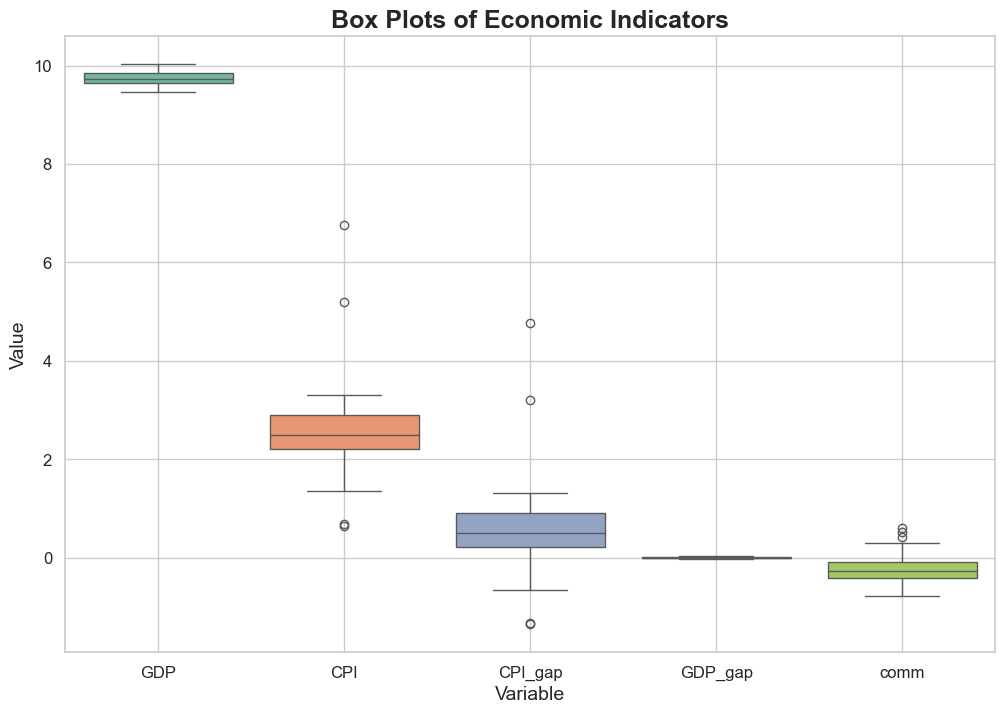

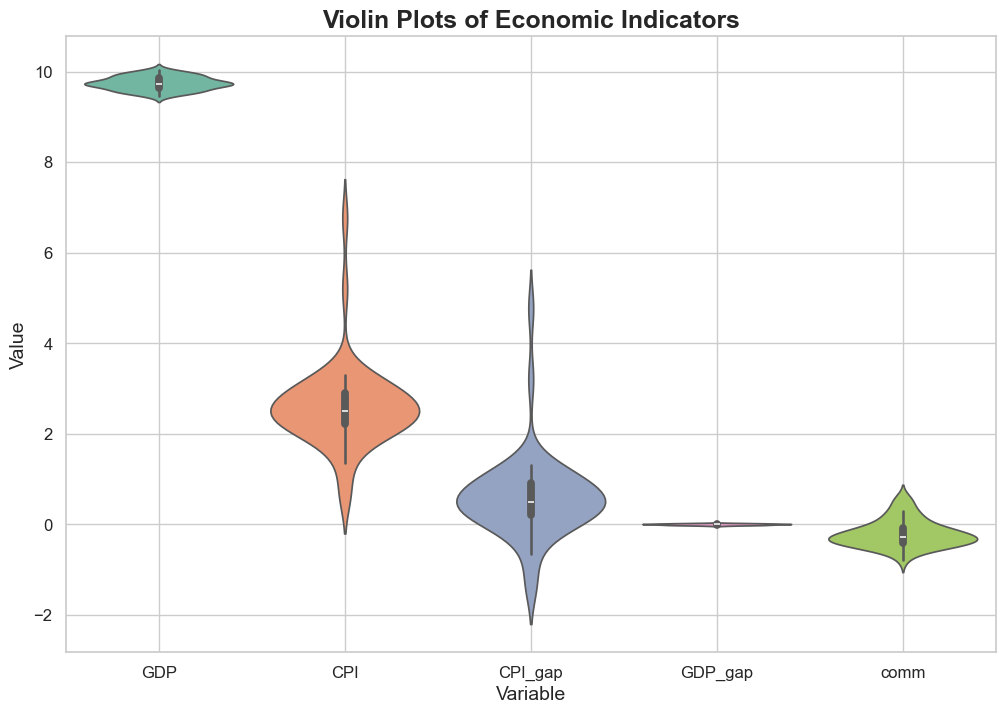

<Figure size 1200x800 with 0 Axes>

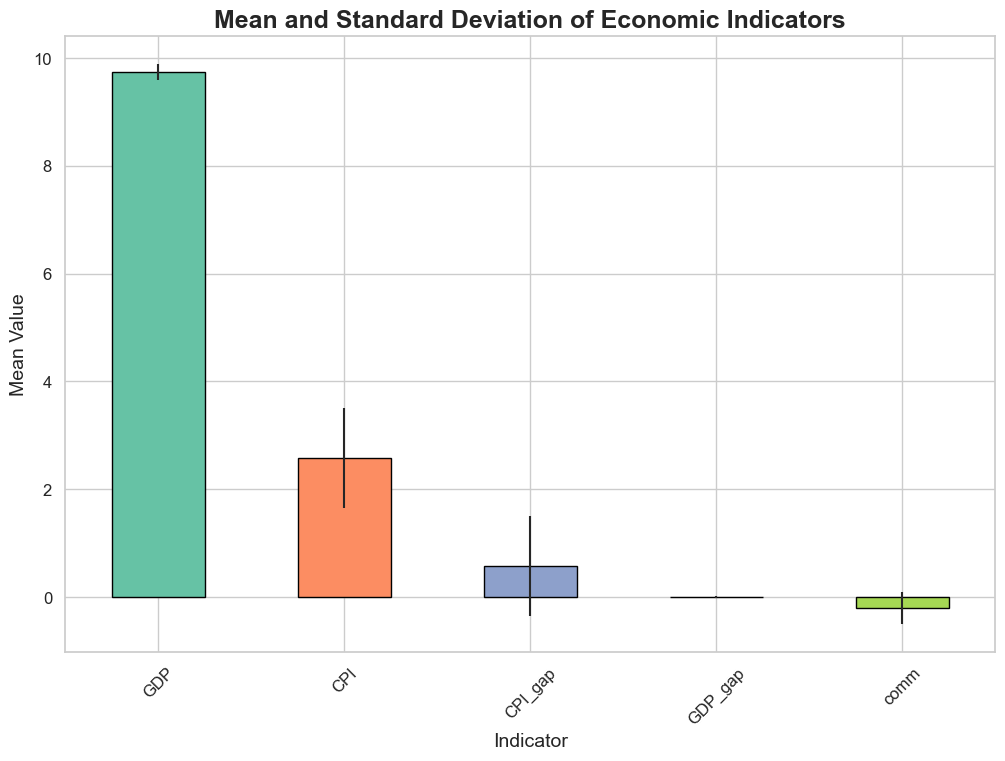

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Set a style
sns.set(style="whitegrid")

# Define the palette
palette = sns.color_palette("Set2", len(columns_to_plot))

# Box Plots
def plot_boxplots(df):
    df_melt = df.melt(var_name="Variable", value_name="Value")
    plt.figure(figsize=(12, 8))
    sns.boxplot(x="Variable", y="Value", hue="Variable", data=df_melt, palette=palette, dodge=False)
    plt.title("Box Plots of Economic Indicators", fontsize=18, fontweight="bold")
    plt.xlabel("Variable", fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.legend([], [], frameon=False)
    plt.show()

# Violin Plots
def plot_violinplots(df):
    df_melt = df.melt(var_name="Variable", value_name="Value")
    plt.figure(figsize=(12, 8))
    sns.violinplot(x="Variable", y="Value", hue="Variable", data=df_melt, palette=palette, dodge=False)
    plt.title("Violin Plots of Economic Indicators", fontsize=18, fontweight="bold")
    plt.xlabel("Variable", fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.legend([], [], frameon=False)
    plt.show()

# Bar Plots of Mean and Standard Deviation
def plot_barplots(df):
    stats_df = df.describe().T[["mean", "std"]]
    plt.figure(figsize=(12, 8))
    stats_df.plot(kind="bar", y="mean", yerr="std", legend=False, color=palette, edgecolor="black", figsize=(12, 8))
    plt.title("Mean and Standard Deviation of Economic Indicators", fontsize=18, fontweight="bold")
    plt.xlabel("Indicator", fontsize=14)
    plt.ylabel("Mean Value", fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.show()

# Plot each type
plot_boxplots(df_final_filtered)
plot_violinplots(df_final_filtered)
plot_barplots(df_final_filtered)


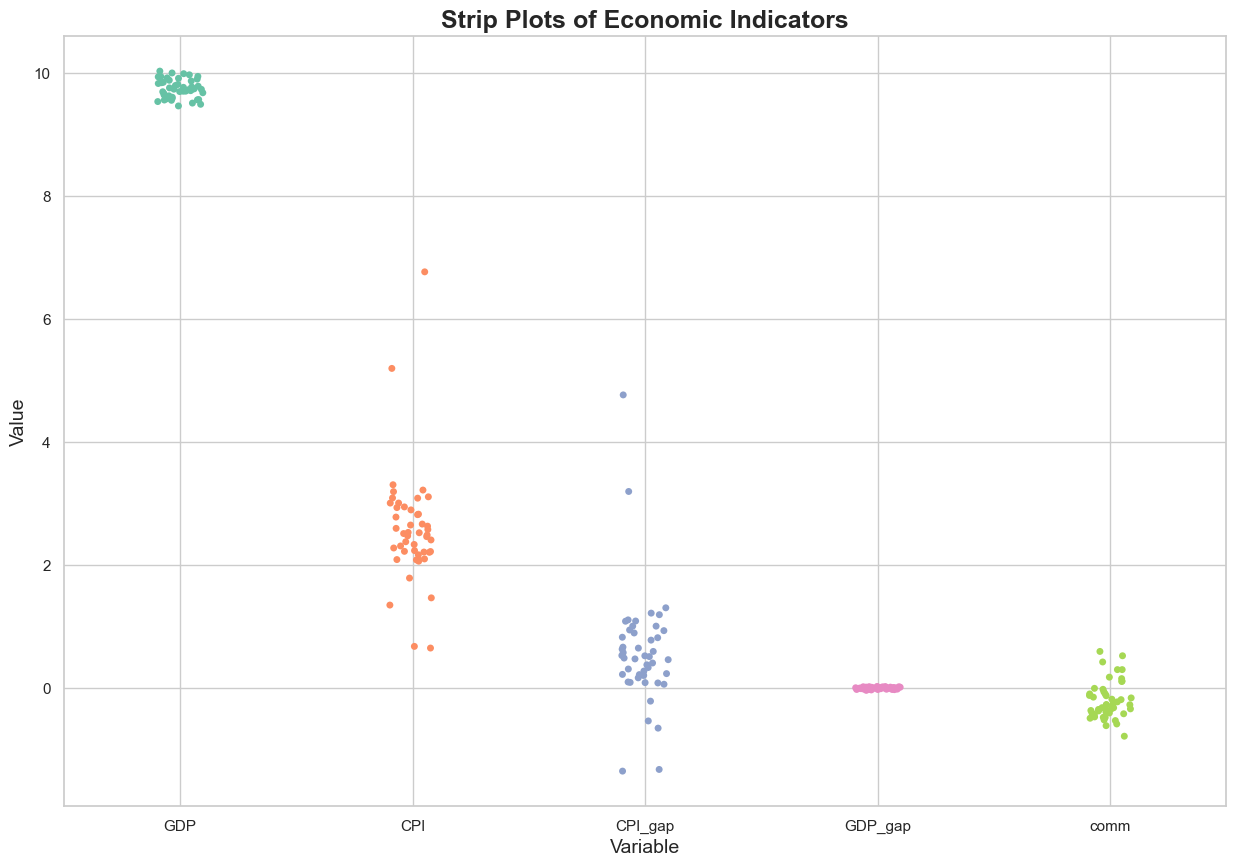

In [74]:
def plot_stripplots(df):
    df_melt = df.melt(var_name="Variable", value_name="Value")
    plt.figure(figsize=(15, 10))
    sns.stripplot(x="Variable", y="Value", hue="Variable", data=df_melt, palette=palette, jitter=True, dodge=False)
    plt.title("Strip Plots of Economic Indicators", fontsize=18, fontweight="bold")
    plt.xlabel("Variable", fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.legend([], [], frameon=False)
    plt.grid(True)
    plt.show()

# Plot strip plots
plot_stripplots(df_final_filtered)

### **8. REGRESSION ANALYSIS**

This section presents a more formal analysis of the tone of Fed communication. The objective is to explore the time-varying nature of central bank communication and the role economic conditions play in explaining variations in the tone at the time when communications took place. 

The study follows a similar approach to Bulir et al. (2013) and arrives at the following specification:

$$
C_t = \alpha + \beta_T T_t + \beta_{\mu} (\mu_t - \mu_t^*) \beta_{\pi} (\pi_t - \pi_t^*) + \beta_{FC} \delta_{FC} + \beta_{cov} \delta_{cov} + \varepsilon_t 
$$

Where:
- $C_t$: is the tone of communication measured using the Loughran-McDonald sentiment dictionary, with higher values indicative of a more positive tone, while lower values suggest a more negative sentiment.
- The model includes two deterministic variables: $\alpha$ is a constant and $T_t$ is a linear trend.
- $\beta_{\mu} (\mu_t - \mu_t^*)$: difference between the logarithmic level of real Gross Domestic Product (GDP, $\mu_t$) and its trend value ($\mu_t^*$), estimated using the Hodrick-Prescott (HP) filter.
- $\beta_{\pi} (\pi_t - \pi_t^*)$: is the absolute difference between contemporaneous inflation ($\pi_t$) and the Fed's inflation target ($\pi_t^*$).
- $\delta_{FC}$ is a dummy variable equal to 1 from 2007:H2 to 2009:H1, 0 otherwise, to capture the effects of the financial crisis. $\delta_{cov}$ is a dummy variable equal to 1 from 2020:H1 to 2023:H2, 0 otherwise, to analyse the Covid-19 period.

#### 8.1 Create Dummy Variables

In [75]:
# Create dummy variable for GFC 
# Create column with zero
df_final["FC"] = 0  

# Dates where FC is equal to 1 
start_date = "2007-07-01"
end_date = "2009-02-01"

# Set "FC" to 1 for the specified date range
df_final.loc[(df_final.index >= start_date) & (df_final.index <= end_date), "FC"] = 1

In [76]:
# Create dummy variable for Covid-19 period
df_final["Covid"] = 0  # Create column with zero

# Dates where Covid is equal to 1 
start_date = "2020-02-01"
end_date = "2023-07-01"

# Set "FC" to 1 for the specified date range
df_final.loc[(df_final.index >= start_date) & (df_final.index <= end_date), "Covid"] = 1

#### 8.2 Create Linear Time Trend

In [77]:
# Create a linear time trend variables
df_final["trend"] = range(1, len(df_final) + 1)

In [78]:
df_final.tail(2)

,GDP,CPI,CPI_gap,GDP_gap,comm,FC,Covid,trend
date,,,,,,,,
2023-02-01,10.00112,6.768873,4.768873,0.001427,-0.578947,0,1,47
2024-02-01,10.03118,5.199520,3.199520,0.009189,-0.090909,0,0,48


#### 8.3 OLS Regression

In [79]:
import math
from sklearn.metrics import mean_squared_error

In [80]:
# Define the Y variable
Y = df_final["comm"]

# Define the X variables
X = df_final[["trend", "CPI_gap", "GDP_gap", "FC", "Covid"]]

# Add a constant term to the X variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(Y, X).fit(cov_type = "HC3")

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   comm   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     5.066
Date:                Wed, 29 May 2024   Prob (F-statistic):            0.00101
Time:                        20:53:05   Log-Likelihood:               0.095492
No. Observations:                  48   AIC:                             11.81
Df Residuals:                      42   BIC:                             23.04
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4437      0.060     -7.365      0.0

In [81]:
# Get predicted values from the model
predicted_values = model.predict(X)

# Calculate the residuals
residuals = Y - predicted_values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y, predicted_values)

# Calculate RMSE
rmse = math.sqrt(mse)

print("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 0.24148982086013515


#### 8.4 Robustness Tests

##### 8.4.1 Multicollinearity

Multicollinearity occurs when two or more independent variables in a regression model are highly correlated with each other. It can lead to challenges in interpreting the effects of individual variables and result in unstable coefficient estimates. To detect and address multicollinearity, we employ the Variance Inflation Factor (VIF).

The VIF measures the extent to which the variance of the estimated regression coefficient is increased due to multicollinearity. A VIF value greater than 1 suggests the presence of multicollinearity, with higher values indicating stronger multicollinearity. Typically, a VIF value greater than 5 is considered problematic.

In [82]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [83]:
# Define X variables
X = df_final[["trend", "CPI_gap", "GDP_gap", "FC", "Covid"]]

# Create a DataFrame to store VIF values
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print the VIF DataFrame
print(vif)

  Variable       VIF
0    trend  1.708805
1  CPI_gap  1.902915
2  GDP_gap  1.264465
3       FC  1.160052
4    Covid  1.508785


##### 8.4.2 Check Normality of Residuals

Checking the normality of residuals means assessing whether the residuals (the differences between observed and predicted values) from your regression model follow a normal distribution. It's an important assumption in linear regression analysis because many inference procedures rely on the assumption that residuals are normally distributed.

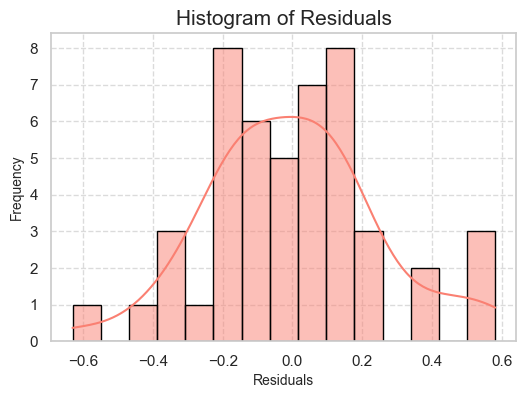

In [84]:
# Get residuals
residuals = model.resid

# Set style
sns.set(style = "whitegrid")

# Set figure size
plt.figure(figsize=(6, 4))

# Plot histogram 
sns.histplot(residuals, bins = 15, kde = True, color = "salmon", edgecolor = "black")

# Add title and labels
plt.title("Histogram of Residuals", fontsize = 15)
plt.xlabel("Residuals", fontsize = 10)
plt.ylabel("Frequency", fontsize = 10)
plt.grid(True, linestyle = '--', alpha = 0.7)

# Display the plot
plt.show()

##### 8.4.3 Check for Residual Autocorrelation (Serial Correlation)

Residual autocorrelation, also known as serial correlation, refers to the correlation between the residuals (errors) of a regression model at different time points or observations. In a time series context, it indicates whether the residuals from one observation are correlated with the residuals from neighboring observations.

Residual autocorrelation can be problematic because it violates the assumption of independence of observations in regression analysis. It can lead to biased coefficient estimates, inflated standard errors, and unreliable hypothesis tests.

In [85]:
import statsmodels.api as sm

In [86]:
# Perform the Durbin-Watson test
durbin_watson_statistic = sm.stats.stattools.durbin_watson(model.resid)

# Print the Durbin-Watson statistic
print("Durbin-Watson Statistic:", durbin_watson_statistic)

Durbin-Watson Statistic: 1.7509391182420058


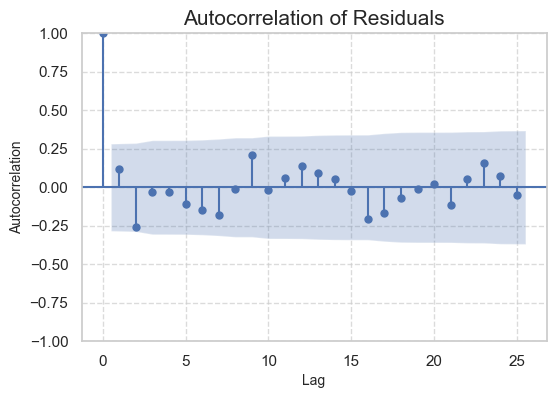

In [87]:
# Plot ACF of residuals
fig, ax = plt.subplots(figsize=(6, 4))

# Plot ACF with customizations
sm.graphics.tsa.plot_acf(model.resid, lags=25, ax=ax, alpha=0.05)

# Customize the appearance
ax.set_xlabel("Lag", fontsize = 10)
ax.set_ylabel("Autocorrelation", fontsize = 10)
ax.set_title("Autocorrelation of Residuals", fontsize = 15)
ax.grid(True, linestyle = "--", alpha = 0.7)

# Show the plot
plt.show()

##### 8.4.4 Heteroscedasticity

The Breusch-Pagan test is a statistical test used to assess whether the variance of the errors (residuals) in a regression model is constant (homoscedastic) or varies systematically with the predictor variables (heteroscedastic).

The null hypothesis of the Breusch-Pagan test is that the variance of the errors is constant (homoscedasticity). The alternative hypothesis is that the variance of the errors varies with one or more of the predictor variables (heteroscedasticity).

If the p-value < 0.05 you reject the null hypothesis of homoscedasticity. This suggests that there is evidence of heteroscedasticity in the model.

In [88]:
import statsmodels.stats.api as sms

In [89]:
# Perform Breusch-Pagan test
bp_test = sms.het_breuschpagan(model.resid, model.model.exog)

# Extract test statistics and p-value
test_statistic = bp_test[0]
p_value = bp_test[1]

# Print test results
print("Breusch-Pagan test statistic:", np.round(test_statistic,4))
print("Breusch-Pagan test p-value:", np.round(p_value,4))

Breusch-Pagan test statistic: 16.0452
Breusch-Pagan test p-value: 0.0067


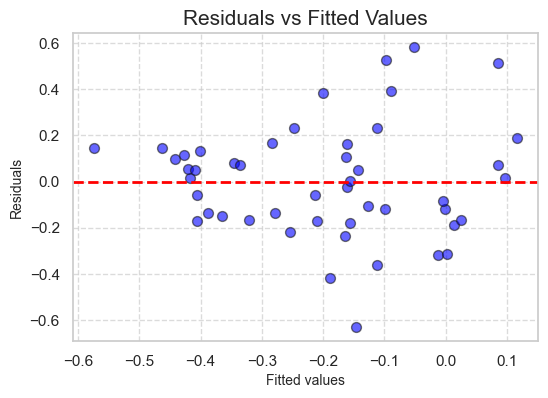

In [90]:
# Plot the residuals against the predicted values
plt.figure(figsize=(6, 4))
plt.scatter(model.fittedvalues, residuals, alpha = 0.6, color = "blue", edgecolors = "k", s = 50)
plt.xlabel("Fitted values", fontsize = 10)
plt.ylabel("Residuals", fontsize = 10)
plt.title("Residuals vs Fitted Values", fontsize = 15)

# Add a horizontal line at y=0 for reference
plt.axhline(y = 0, color = "red", linestyle = "--", linewidth = 2) 
plt.grid(True, linestyle = "--", alpha = 0.7)
plt.show()